# BaseLine Transformer

Caution: This is not a usual use case of Transformer.

Transformer developed by Google usually use Embeddeding Layer to represents a target such as a word.

In this model, I use OHLC as a state vector though we can take the same approch for finance data as the word.
In this case, since d_model is very low this would be not a good choice for a Transformer model.

Parameters:
- Input:  ohlc_df.iloc[index] with observation length (i.e. shape is (observation_length, batch_size, 4))
- Target: ohlc_df.iloc[index+observation_length] with prediction length (i.e. shape is (prediction_length, batch_size, 4))

In [ ]:
import csv
from datetime import datetime
import json
import math
import os
import sys
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path = '/content/drive'
  base_folder = os.path.join(mount_path, "My Drive", "Data")
  data_folder = os.path.join(base_folder, "FX")
else:
  base_folder = '../../../Data'
  data_folder = os.path.join(base_folder, "FX", "OANDA-Japan MT5 Live")

In [3]:
import os
import shutil
import sys
import zipfile
import requests

def download_modlue_from_gh(repository, github_account='Naradice', branch='master', folder=None, module_path='/gdrive/My Drive/modules', **kwargs):
  if folder is None:
    folder = repository

  zip_url = f"https://github.com/{github_account}/{repository}/archive/refs/heads/{branch}.zip"
  response = requests.get(zip_url)
  if response.status_code == 200:
    with open("temp.zip", "wb") as f:
      f.write(response.content)
    with zipfile.ZipFile("temp.zip", "r") as zip_ref:
      zip_ref.extractall("temp_dir")

    source_folder = f"temp_dir/{repository}-{branch}/{folder}"
    destination_folder = os.path.join(module_path, folder)
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
    os.remove("temp.zip")
    shutil.rmtree("temp_dir")
  else:
    print(f"filed to download {zip_url}: {response.status_code}, {response.text}")

In [4]:
if IS_GOOGLE_COLAB:
  drive.mount(mount_path)
  module_path = f"{mount_path}/My Drive/modules"
else:
  module_path = '../../modules'

if os.path.exists(module_path) is False:
  os.makedirs(module_path)

repositories = [
    {'repository': 'stocknet_study', 'branch': 'master', 'folder': 'Dataset', 'refresh': False},
    {'repository': 'finance_process', 'branch': 'master', 'folder': 'fprocess', 'refresh': True},
    {'repository': 'cloud_storage_handler', 'branch': 'main', 'folder': 'cloud_storage_handler', 'refresh': False},
]

destination = os.path.join(module_path, '__init__.py')
if os.path.exists(destination) is False:
  with open(destination, mode='w') as fp:
    fp.close()

for repo_kwargs in repositories:
  destination = os.path.join(module_path, repo_kwargs['folder'])
  if repo_kwargs['refresh'] or os.path.exists(destination) is False:
    download_modlue_from_gh(**repo_kwargs, module_path=module_path)

Mounted at /content/drive


In [5]:
sys.path.append(module_path)

import fprocess
import Dataset
import cloud_storage_handler

In [29]:
class Logger:

  @classmethod
  def connect_drive(cls, mount_path='/content/drive'):
    from google.colab import drive
    drive.mount(mount_path)

  def __init__(self, model_name, version, base_path=None, storage_handler='colab', max_retry=3, local_cache_period=10, client_id=None):
    """ Logging class to store training logs

    Args:
        model_name (str): It create a folder {base_path}/{model_name}/.
        verison (str): It create a file {base_path}/{model_name}/{model_name}_v{version}.csv.
        base_path (str, optional): Base path to store logs. If you use cloud storage, this is used as temporal folder. Defaults to None.
        storage_handler (str|BaseHandler, optional): It change storage service. 'colab' can be selected. Defaults to 'colab'.
        max_retry (int, optional): max count of retry when store logs via network. Defaults to 3.
        local_cache_period(int, optional): Valid for cloud storage only. period to chache logs until send it to the storage. Defaults to 10.
        client_id(str, optional): client_id to authenticate cloud service with OAuth2.0/OIDC. Defaults to None.
    """
    # define common veriables
    MOUNT_PATH = '/content/drive'
    self.__use_cloud_storage = False
    self.__init_storage = lambda : None
    self.__local_cache_period = local_cache_period
    self.model_name = model_name
    self.version = version
    self.max_retry = max_retry

    # define variables depends on env
    if storage_handler == 'colab':
      # this case we store logs on mounted path
      self.__init_colab()
      self.__init_storage = self.__init_colab
      if base_path is None:
        self.base_path = MOUNT_PATH
      else:
        base_pathes = [p for p in base_path.split('/') if len(p) > 0]
        self.base_path = os.path.join(MOUNT_PATH, 'My Drive', *base_pathes)
    elif type(storage_handler) is str:
      raise ValueError(f"{storage_handler} is not supported. Please create StorageHandler for the service.")
    elif storage_handler is not None:
      # this case we store logs on app folder of dropbox, using cloud_storage_handlder
      self.__cloud_handler = storage_handler
      if self.__cloud_handler.refresh_token is None:
        self.__cloud_handler.authenticate()
      self.__use_cloud_storage = True
      if base_path is None:
        self.base_path = './'
      else:
        self.base_path = base_path
    else:
      if base_path is None:
        self.base_path = './'
      else:
        self.base_path = base_path
    model_log_folder = os.path.join(self.base_path, model_name)
    if not os.path.exists(model_log_folder):
        os.makedirs(model_log_folder)
    file_name = f"{model_name}_v{version}.csv"
    self.log_file_path = os.path.join(model_log_folder, file_name)
    self.__cache = []

  def __init_colab(self):
    from google.colab import drive
    drive.mount(MOUNT_PATH)

  def __store_files_to_cloud_storage(self, file_path):
    try:
      self.__cloud_handler.upload_training_results(self.model_name, [file_path])
    except Exception as e:
      print(f"failed to save logs to dropbox: {e}")

  def reset(self, model_name=None, file_name=None):
    if file_name is None:
      file_name = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    if model_name is None:
      if file_name is None:
        raise ValueError("Either model_name or file_name should be specified")
      self.log_file_path = os.path.join(self.base_path, file_name)
    else:
      model_log_folder = os.path.join(self.base_path, model_name)
      if not os.path.exists(model_log_folder):
        os.makedirs(model_log_folder)
      self.log_file_path = os.path.join(model_log_folder, file_name)
    self.__cache = []

  def __cache_log(self, log_entry: list):
    self.__cache.append(log_entry)

  def __append_log(self, log_entry:list, retry_count=0):
      try:
          with open(self.log_file_path, 'a') as log_file:
            writer = csv.writer(log_file)
            if len(self.__cache) > 0:
              writer.writerows(self.__cache)
              self.__cache = []
            writer.writerow(log_entry)
      except Exception as e:
        if retry_count < self.max_retry:
          if retry_count == 0:
            print(e)
          self.__init_storage()
          self.__append_log(log_entry, retry_count+1)
        else:
          self.__cache.append(log_entry)

  def save_params(self, params:dict, model_name=None, model_version=None):
    data_folder = os.path.dirname(self.log_file_path)
    param_file_path = os.path.join(data_folder, f'{model_name}_v{model_version}_params.json')
    with open(param_file_path, mode="w") as fp:
      json.dump(params, fp)
    if self.__use_cloud_storage:
      self.__store_files_to_cloud_storage(param_file_path)

  def save_model(self, model, model_name=None, model_version=None):
    if model is not None:
      data_folder = os.path.dirname(self.log_file_path)
      param_file_path = os.path.join(data_folder, f'{model_name}_v{model_version}.torch')
      torch.save(model.state_dict(), param_file_path)
      if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(param_file_path)

  def save_checkpoint(self, model, optimizer, scheduler, model_name, model_version, **kwargs):
    if model is not None:
      data_folder = os.path.dirname(self.log_file_path)
      model_path = os.path.join(data_folder, f'{model_name}_v{model_version}.torch')
      torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        **kwargs
      }, model_path)
      if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(model_path)

  def save_logs(self):
    if len(self.__cache) > 0:
      with open(self.log_file_path, 'a') as log_file:
        if len(self.__cache) > 0:
          writer = csv.writer(log_file)
          writer.writerows(self.__cache)
    if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(self.log_file_path)

  def add_training_log(self, training_loss, validation_loss, log_entry:list=None):
    timestamp = datetime.now().isoformat()
    basic_entry = [timestamp, training_loss, validation_loss]
    if log_entry is not None:
      if type(log_entry) is list and len(log_entry) > 0:
        basic_entry.extend(log_entry)
    if len(self.__cache) < self.__local_cache_period:
      self.__cache_log(basic_entry)
    else:
      self.__append_log(basic_entry)
      if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(self.log_file_path)

  def get_min_losses(self, train_loss_column=1, val_loss_column=2):
    logs = None
    if os.path.exists(self.log_file_path) is False:
      file_name = os.path.dirname(self.log_file_path)
      destination_path = f'/{self.model_name}/{file_name}'
      response = self.__cloud_handler.download_file(destination_path, self.log_file_path)
      if response is not None:
        logs = pd.read_csv(self.log_file_path)
    else:
      logs = pd.read_csv(self.log_file_path)

    if logs is None:
      print("no log available")
      return np.inf, np.inf
    else:
      if type(train_loss_column) is int:
        train_loss = logs.iloc[:, train_loss_column]
      elif type(train_loss_column) is str:
        train_loss = logs[train_loss_column]
      min_train_loss = train_loss.min()

      if type(val_loss_column) is int:
        val_loss = logs.iloc[:, val_loss_column]
      elif type(val_loss_column) is str:
        val_loss = logs[val_loss_column]
      min_val_loss = val_loss.min()

      return min_train_loss, min_val_loss

In [ ]:
# Initialize cloud storage handler if needed
from cloud_storage_handler import DropboxHandler


storage_handler = DropboxHandler("nhjrq1cjpugk5hc", "http://localhost")
storage_handler.authenticate()
# Otherwise, specify None
# storage_handler = None

In [8]:
def load_model(model_name, model_version, device, train=True, storage_handler=None, model_folder=None, optimizer_class=None, scheduler_class=None):
  if model_folder is None:
    model_folder = base_folder
  model_folder = os.path.join(model_folder, model_name)

  params_file_name = f'{model_folder}/{model_name}_v{model_version}_params.json'
  if os.path.exists(params_file_name) is False:
    if storage_handler is None:
      print(f"exsisting model params not found on {params_file_name}.")
      return None, None, None, None
    else:
      response = storage_handler.download_file(f"/{model_name}/{model_name}_v{model_version}_params.json", params_file_name)
      if response is None:
        print("exsisting model params not found.")
        return None, None, None, None
  with open(params_file_name) as fp:
      params = json.load(fp)
  # need to create create_model function for respective model
  model = create_model(**params, feature_size=len(params["features"])).to(device)
  optimizer = optimizer_class(model.parameters(), lr=lr)
  scheduler = scheduler_class(optimizer, 1.0)
  if train:
    model_path = f'{model_folder}/{model_name}_train_v{model_version}.torch'
  else:
    model_path = f'{model_folder}/{model_name}_v{model_version}.torch'
  if os.path.exists(model_path) is False:
    if storage_handler is None:
      print("exsisting model not found.")
      return None, None, None, None
    file_name = os.path.basename(model_path)
    response = storage_handler.download_file(f"/{model_name}/{file_name}", model_path)
    if response is None:
      print("exsisting model not found.")
      return None, None, None, None

  if torch.cuda.is_available():
    check_point = torch.load(model_path)
  else:
    check_point = torch.load(model_path, map_location=torch.device('cpu'))
  if "model_state_dict" in check_point:
    model.load_state_dict(check_point['model_state_dict'])
    optimizer.load_state_dict(check_point['optimizer_state_dict'])
    scheduler.load_state_dict(check_point['scheduler_state_dict'])
    return params, model, optimizer, scheduler
  else:
    if optimizer_class is not None:
      print("checkpoint is not available.")
    model.load_state_dict(check_point)
    return params, model, None, None

# Basic Transformer model

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(-2)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(0)
        tgt_pos = src_pos + tgt.size(0) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [10]:
class Seq2SeqTransformer(nn.Module):

    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):

        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(feature_size, dropout=dropout)

        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self, src: Tensor, tgt: Tensor, mask_tgt: Tensor,
        mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):

        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

In [11]:
def create_model(num_encoder_layers, num_decoder_layers, feature_size, dim_feedforward, dropout, nhead, **kwargs):
    model = Seq2SeqTransformer(
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        feature_size=feature_size,
        dim_feedforward=dim_feedforward,
        dropout=dropout, nhead=nhead
    )
    return model

In [12]:
def train(model, ds, optimizer, criterion, batch_size, device):

    model.train()
    ds.train()
    losses = 0

    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index - batch_size, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, tgt=input_tgt,  mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / length

In [13]:
def evaluate(model, ds, criterion, batch_size, device):

    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)

        logits = model(
            src=src, tgt=input_tgt, mask_tgt=mask_tgt,
        )

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()

    return losses / length

In [14]:
def prediction(model, inputs, feature_size, prediction_length, device):

    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    while preds.size(0) <= prediction_length:
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, tgt=preds,  mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

## Row Data

Since we shouldn't expose data obtained from other service, csv is not committed to this repository.
Please preprare your data and load it.

In [42]:
import os
import pandas as pd

ohlc_column = ['open','high','low','close']
file_name = "mt5_USDJPY_min30.zip"

file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df

open     high      low    close  tick_volume  spread  \
time                                                                           
2014-07-07 08:30:00  102.086  102.122  102.081  102.102          738       3   
2014-07-07 09:00:00  102.102  102.146  102.098  102.113         1036       3   
2014-07-07 09:30:00  102.113  102.115  102.042  102.044          865       3   
2014-07-07 10:00:00  102.047  102.052  102.005  102.019          983       3   
2014-07-07 10:30:00  102.017  102.025  101.918  101.941         1328       3   
...                      ...      ...      ...      ...          ...     ...   
2022-08-12 21:30:00  133.461  133.506  133.439  133.484         1125       3   
2022-08-12 22:00:00  133.484  133.530  133.437  133.475         1277       3   
2022-08-12 22:30:00  133.475  133.486  133.433  133.483         1506       3   
2022-08-12 23:00:00  133.484  133.536  133.465  133.521         1038       3   
2022-08-12 23:30:00  133.521  133.522  133.301  133.313         2515       3   

                     real_volume  
time                              
2014-07-07 08:30:00            0  
2014-07-07 09:00:00            0  
2014-07-07 09:30:00            0  
2014-07-07 10:00:00            0  
2014-07-07 10:30:00            0  
...                          ...  
2022-08-12 21:30:00            0  
2022-08-12 22:00:00            0  
2022-08-12 22:30:00            0  
2022-08-12 23:00:00            0  
2022-08-12 23:30:00            0  

[100720 rows x 7 columns]

In [43]:
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
ohlc_pre_process = [diff_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [44]:
from Dataset.transformer import FeatureDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_transformer"

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10
feature_size = 4

ds = FeatureDataset(df, columns, processes=processes,
             observation_length=observation_length, prediction_length=prediction_length, device=device)

### Training

In [ ]:
model_version = "0"
model_params, model, optimizer, scheduler = load_model(model_name, model_version, device, True, storage_handler=storage_handler,
                                 optimizer_class=torch.optim.Adam,
                                 scheduler_class=torch.optim.lr_scheduler.StepLR)

if model is None:
    print("Initialize a new model.")

    # Hyper parameters
    model_params = {
        "nhead": 1,
        "dim_feedforward": 1,
        "num_encoder_layers": 1,
        "num_decoder_layers": 1,
        "dropout": 0.1
    }

    model = create_model(
        feature_size=feature_size,
        **model_params
    ).to(device)

params_num = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params_num += p.numel()
print(f"params: {params_num}")

In [50]:
lr = 0.0005

criterion = nn.MSELoss()
if optimizer is None:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [51]:
logger = Logger(model_name, model_version, base_folder, storage_handler=storage_handler, local_cache_period=1)

start_index, end_index = ds.get_date_range()
params = {"processes": fprocess.preprocess_to_params(processes),
          "source": {
              "path": file_path,
              "start": start_index.isoformat(),
              "end": end_index.isoformat(),
              "length": len(ds)
          },
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          **model_params,
          "params_num": params_num,
          "version": 2
}

logger.save_params(params, model_name, model_version)

print("training log will be saved on ", logger.log_file_path)

training log will be saved on  /content/drive/My Drive/Data/finance_basic_transformer/finance_basic_transformer_v0.csv


In [ ]:
epoch = 500
best_train_loss, best_valid_loss = logger.get_min_losses()
best_model = None
best_train_model = None
patience = 3
counter = 0

for loop in range(1, epoch + 1):

    start_time = time.time()

    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )

    elapsed_time = time.time() - start_time

    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )

    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_valid_loss > loss_valid else ''
    )
    print(log)
    logger.add_training_log(loss_train, loss_valid, elapsed_time)

    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
          logger.save_checkpoint(best_train_model, optimizer, scheduler, f'{model_name}_train', model_version)
        scheduler.step()
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        logger.save_model(best_model, optimizer, scheduler, model_name, model_version)

    if counter > patience:
        break
    
logger.save_checkpoint(best_train_model, f'{model_name}_train', model_version)
logger.save_checkpoint(best_model, model_name, model_version)

In [ ]:
if IS_GOOGLE_COLAB:
    # run this method if you want to disconnect runtime after the traning ends
    from google.colab import runtime

    drive.flush_and_unmount()
    runtime.unassign()

### Validation

In [53]:
model_name = "finance_basic_transformer"
model_version = 0
_, model = load_model(model_name, model_version, device, False, storage_handler=storage_handler)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [79]:
# Confirm validaton methods

ds.train()
src, tgt = ds[:16]

tgt_values = tgt.cpu().detach().numpy()
src_values = src.cpu().detach().numpy()

tgt_values.shape

(11, 16, 4)

In [ ]:
from Dataset import revert_process

r_data = revert_process.revert(ds, src_values, [index for index in range(0, 16)], is_tgt=False)
# reverted open values
r_data[:, 0, 0]

In [ ]:
# Confirm original values
index = ds.get_actual_index([0])[0]
df[ohlc_column].iloc[index:index+observation_length]

In [54]:
from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 1000
split_index = int(len(ds)/split_factor)
# set feature_size of input: (observation_length, batch_size, feature_size)
feature_size = 4

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))

    preds = prediction(model, val_inp, feature_size, prediction_length, device)
    pre_values = preds.cpu().detach().numpy()

    ohlc = revert_process.revert(ds, pre_values, ndx, True)

    if factor == 0:
        ohlc_pre = ohlc
        ohlc_pre_org = pre_values
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
        ohlc_pre_org = np.append(ohlc_pre_org, pre_values, axis=1)

    ans_values = val_ans.cpu().detach().numpy()

    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True)

    if factor == 0:
        ohlc_ans = temp_ohlc
        ohlc_ans_org = ans_values
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)
        ohlc_ans_org = np.append(ohlc_ans_org, ans_values, axis=1)

[]

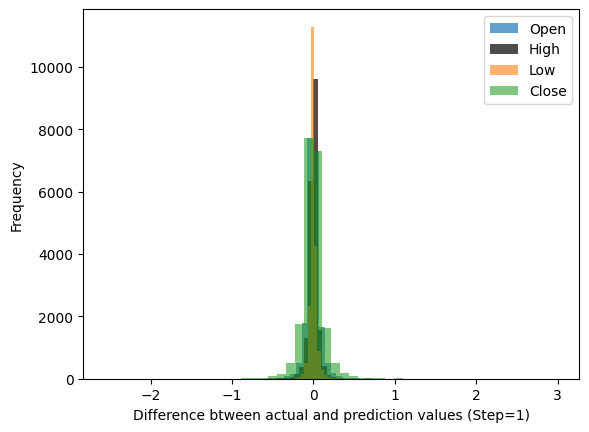

In [55]:
import matplotlib.pyplot as plt

step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

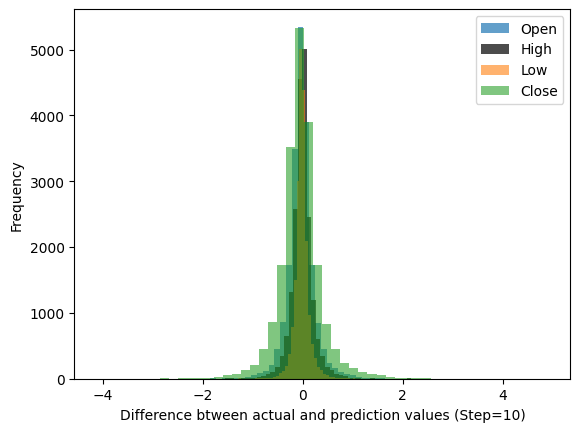

In [56]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [57]:
diff_array = ohlc_pre[1:] - ohlc_ans[1:]
columns = ["open", "high", "low", "close"]
mean_df = pd.DataFrame(np.mean(diff_array, axis=1), columns=columns)
var_df = pd.DataFrame(np.var(diff_array, axis=1), columns=columns)

print(mean_df)
print(var_df)

       open      high       low     close
0 -0.003431 -0.000808 -0.001409 -0.004299
1 -0.007363 -0.001333 -0.002807 -0.008476
2 -0.011587 -0.001693 -0.004200 -0.012587
3 -0.015521 -0.002214 -0.005598 -0.016761
4 -0.019172 -0.002883 -0.006999 -0.020999
5 -0.022057 -0.003978 -0.008413 -0.025416
6 -0.024467 -0.005339 -0.009838 -0.029952
7 -0.027185 -0.006532 -0.011257 -0.034408
8 -0.030426 -0.007429 -0.012665 -0.038741
9 -0.034382 -0.007928 -0.014061 -0.042908
       open      high       low     close
0  0.008240  0.004279  0.002057  0.019647
1  0.016082  0.009535  0.004412  0.038502
2  0.024255  0.014911  0.006774  0.058155
3  0.032276  0.020203  0.009017  0.077448
4  0.040509  0.025532  0.011248  0.097262
5  0.048670  0.030833  0.013492  0.116908
6  0.056999  0.036106  0.015773  0.136892
7  0.065343  0.041393  0.018052  0.157012
8  0.073520  0.046739  0.020327  0.176794
9  0.081852  0.052028  0.022561  0.196832


[]

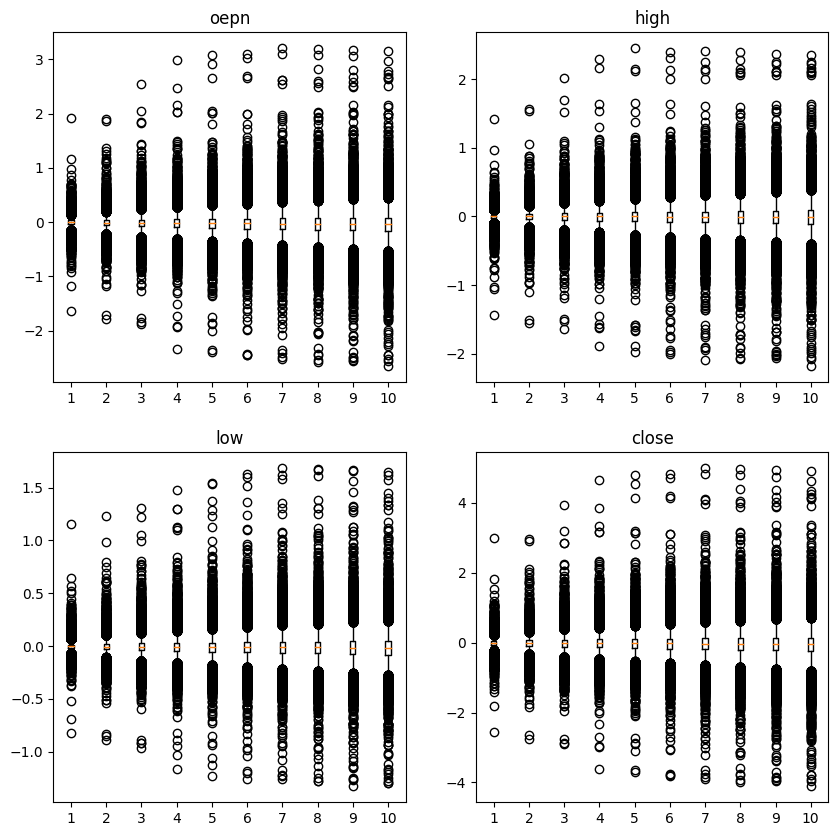

In [58]:
quant_1_df = pd.DataFrame(np.quantile(diff_array, 0.25, axis=1), columns=columns)
quant_2_df = pd.DataFrame(np.quantile(diff_array, 0.5, axis=1), columns=columns)
quant_3_df = pd.DataFrame(np.quantile(diff_array, 0.75, axis=1), columns=columns)
min_df = pd.DataFrame(np.min(diff_array, axis=1), columns=columns)
max_df = pd.DataFrame(np.max(diff_array, axis=1), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for index in range(0, 10):
  axs[0,0].boxplot(diff_array[index, :, 0], positions=[index+1])
  axs[0,1].boxplot(diff_array[index, :, 1], positions=[index+1])
  axs[1,0].boxplot(diff_array[index, :, 2], positions=[index+1])
  axs[1,1].boxplot(diff_array[index, :, 3], positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

[]

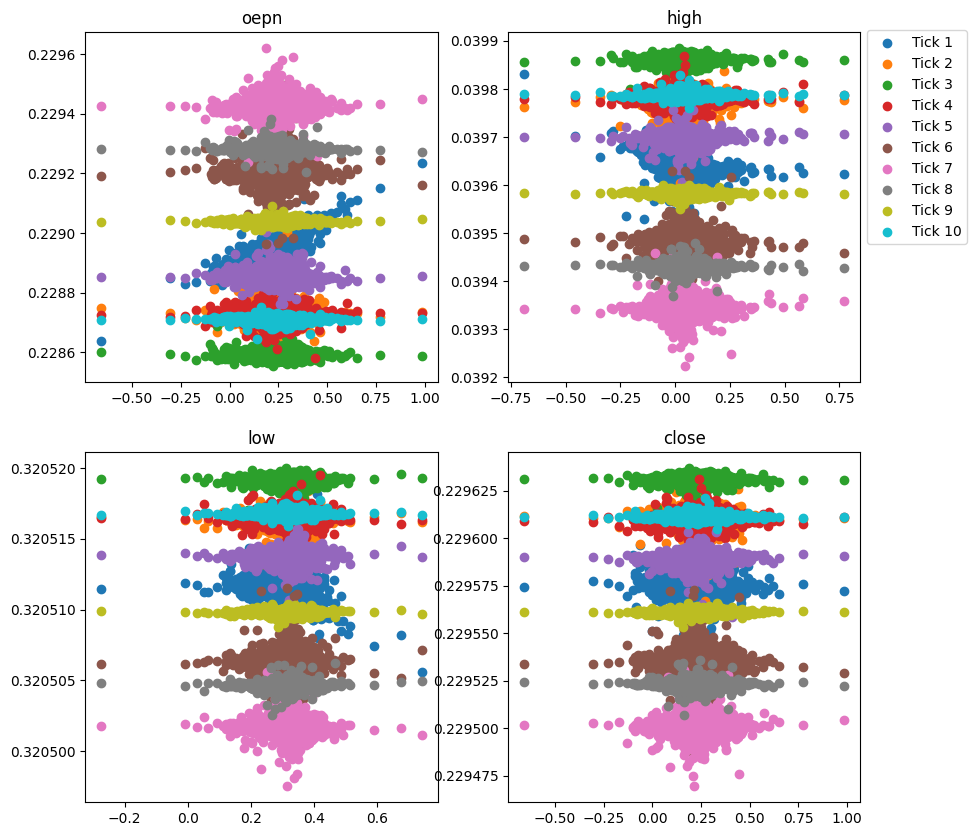

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for step in range(1, 11):

  axs[0,0].scatter(ohlc_ans_org[step, :, 0], ohlc_pre_org[step, :, 0], label=f'Tick {step}')
  axs[0,1].scatter(ohlc_ans_org[step, :, 1], ohlc_pre_org[step, :, 1], label=f'Tick {step}')
  axs[1,0].scatter(ohlc_ans_org[step, :, 2], ohlc_pre_org[step, :, 2], label=f'Tick {step}')
  axs[1,1].scatter(ohlc_ans_org[step, :, 3], ohlc_pre_org[step, :, 3], label=f'Tick {step}')
axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

In [60]:
diff_array_org = ohlc_pre_org[1:] - ohlc_ans_org[1:]
mean_org_df = pd.DataFrame(np.mean(diff_array_org, axis=1), columns=["open", "high", "low", "close"])
var_org_df = pd.DataFrame(np.var(diff_array_org, axis=1), columns=["open", "high", "low", "close"])

print(mean_org_df)
print(var_org_df)

       open      high       low     close
0 -0.001579 -0.000414 -0.000722 -0.001275
1 -0.001809 -0.000270 -0.000717 -0.001239
2 -0.001944 -0.000185 -0.000715 -0.001219
3 -0.001810 -0.000267 -0.000717 -0.001238
4 -0.001680 -0.000343 -0.000718 -0.001257
5 -0.001328 -0.000562 -0.000725 -0.001310
6 -0.001109 -0.000698 -0.000730 -0.001345
7 -0.001250 -0.000612 -0.000728 -0.001322
8 -0.001491 -0.000460 -0.000722 -0.001285
9 -0.001820 -0.000256 -0.000716 -0.001236
       open      high       low     close
0  0.001744  0.001126  0.000541  0.001728
1  0.001745  0.001126  0.000541  0.001728
2  0.001745  0.001126  0.000541  0.001728
3  0.001745  0.001126  0.000541  0.001729
4  0.001745  0.001126  0.000541  0.001729
5  0.001745  0.001126  0.000541  0.001729
6  0.001745  0.001126  0.000541  0.001729
7  0.001745  0.001126  0.000541  0.001729
8  0.001745  0.001126  0.000541  0.001728
9  0.001745  0.001126  0.000541  0.001729


[]

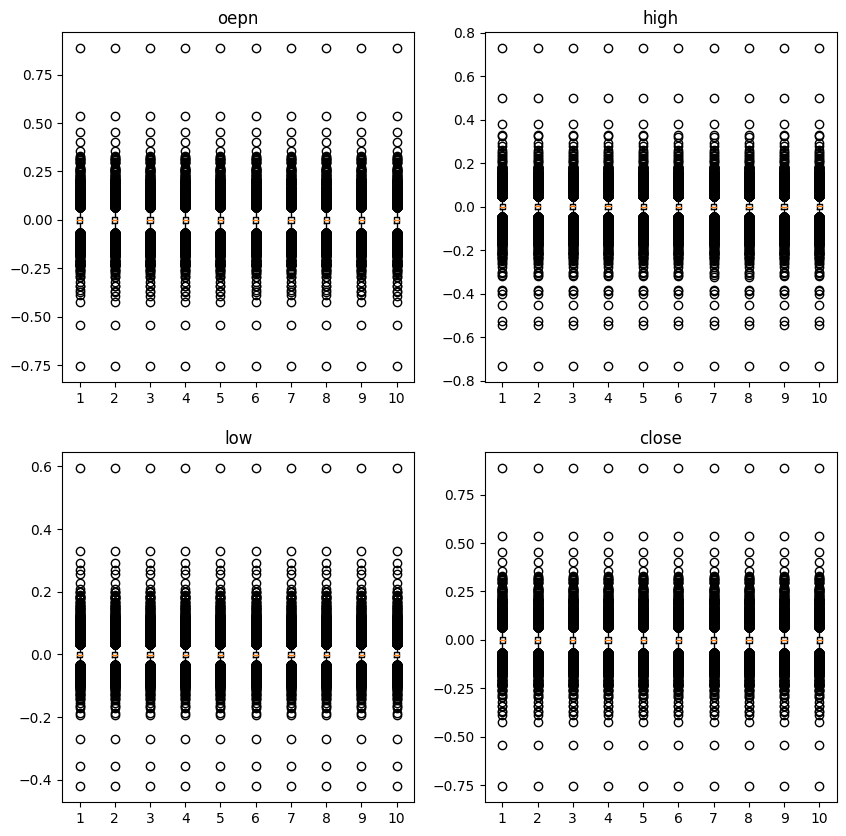

In [61]:
quant_1_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.25, axis=1), columns=columns)
quant_2_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.5, axis=1), columns=columns)
quant_3_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.75, axis=1), columns=columns)
min_org_df = pd.DataFrame(np.min(diff_array_org, axis=1), columns=columns)
max_org_df = pd.DataFrame(np.max(diff_array_org, axis=1), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for index in range(0, 10):
  axs[0,0].boxplot(diff_array_org[index, :, 0], positions=[index+1])
  axs[0,1].boxplot(diff_array_org[index, :, 1], positions=[index+1])
  axs[1,0].boxplot(diff_array_org[index, :, 2], positions=[index+1])
  axs[1,1].boxplot(diff_array_org[index, :, 3], positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

In [62]:
validation_file_path = f'{data_folder}/{model_name}/{model_name}_v{model_version}_validation.csv'
validation_df = pd.concat([
    mean_df, var_df, quant_1_df, quant_2_df, quant_3_df, min_df, max_df,
    mean_org_df, var_org_df, quant_1_org_df, quant_2_org_df, quant_3_org_df, min_org_df, max_org_df,
    ],
    keys=[
        "mean", "var", "q1", "q2", "q3", "min", "max",
        "org_mean", "org_var", "org_q1", "org_q2", "org_q3", "org_min", "org_max"
        ],
    axis=1)
validation_df.to_csv(validation_file_path)
if storage_handler is not None:
    destination_file_path = f'/{model_name}/{model_name}_v{model_version}_validation.csv'
    storage_handler.upload_file(validation_file_path, destination_file_path)

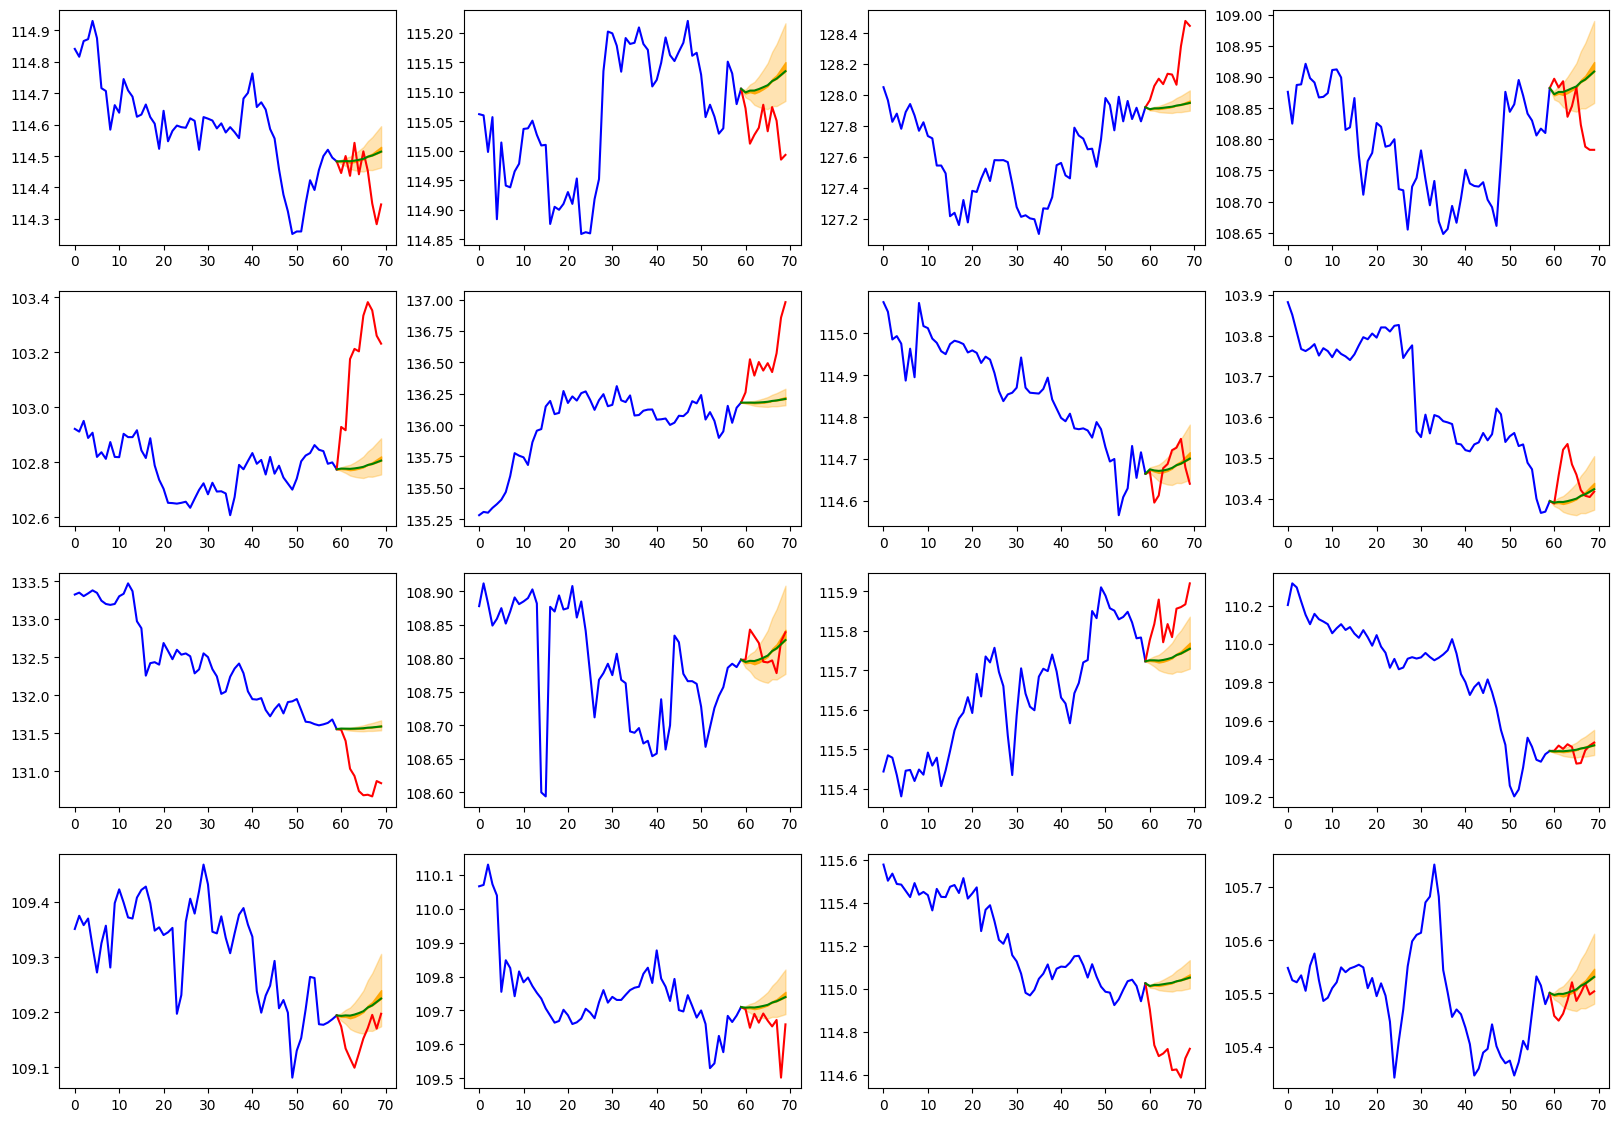

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)

for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[3]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 3], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

###  Summary

In [63]:
model_name = "finance_basic_transformer"
model_versions = [0, 1, 2, 3, 4]

for model_version in model_versions:
  destination_path = f"/{model_name}/{model_name}_v{model_version}.csv"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}.csv"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}.csv was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}.csv")

  destination_path = f"/{model_name}/{model_name}_v{model_version}_params.json"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}_params.json"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}_params.json was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}_params.json")

  destination_path = f"/{model_name}/{model_name}_v{model_version}_validation.csv"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}_validation.csv"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}_validation.csv was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}_validation.csv")

finance_basic_transformer_v0.csv was downloaded
finance_basic_transformer_v0_params.json was downloaded


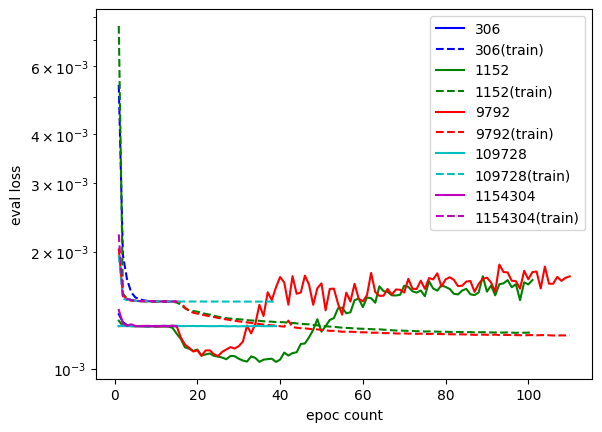

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
logs_files = glob.glob(f"{data_folder}/{model_name}/{model_name}*_params.json")
logs_files.sort()

eval_loss = []
train_loss = []
eval_params = []

for index, log_file in enumerate(logs_files):
    color_index = index % len(colors)
    with open(log_file) as fp:
        params = json.load(fp)
    params_num = params["params_num"]
    log_file = log_file.replace("_params.json", ".csv")
    logs = pd.read_csv(log_file, header=None)
    logs = logs.iloc[1:]
    logs.columns = ["time","train_loss", "eval_loss"]
    eval_params.append(params_num)
    eval_loss.append(logs.eval_loss.min())
    train_loss.append(logs.train_loss.min())
    plt.yscale("log")
    plt.plot([*logs.index], logs.eval_loss, label=params_num, color=colors[color_index])
    plt.plot([*logs.index], logs.train_loss, label=f"{params_num}(train)", linestyle='--', color=colors[color_index])
plt.xlabel("epoc count")
plt.ylabel("eval loss")
plt.legend()
plt.show()

[]

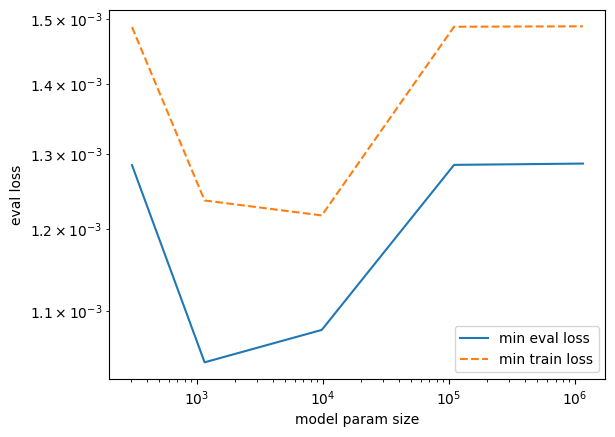

In [65]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("model param size")
plt.ylabel("eval loss")
plt.plot(eval_params, eval_loss, label="min eval loss")
plt.plot(eval_params, train_loss, linestyle="--", label="min train loss")
plt.legend()
plt.plot()

[]

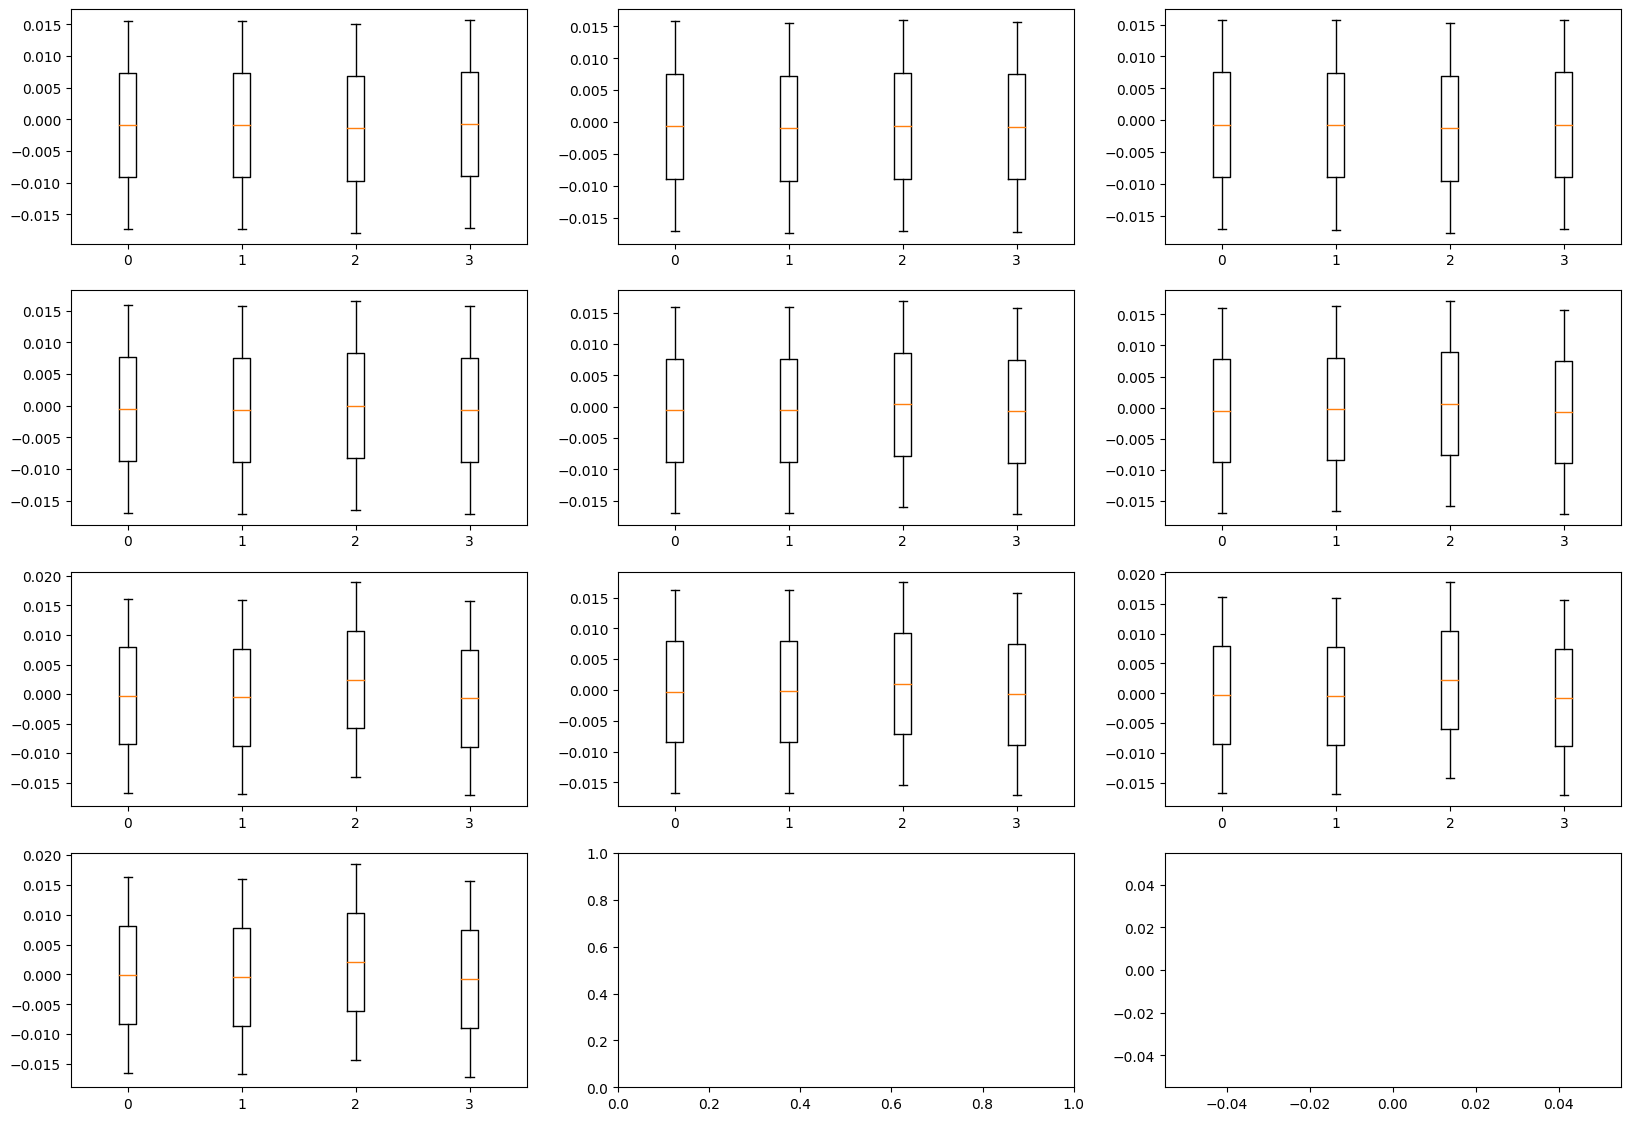

In [36]:
fig, axs = plt.subplots(4, 3, figsize=(20, 14))

for version_index in range(1, 5):
  version_index = version_index -1
  log_file = logs_files[version_index].replace("_params.json", "_validation.csv")
  validation_df = pd.read_csv(log_file, header=[0, 1], index_col=0)
  validation_df.columns = validation_df.columns.swaplevel(0, 1)

  quantile_df = validation_df["close"][["org_q1", "org_q2", "org_q3"]]
  for index in range(0, 10):
    x_index = index // 3
    y_index = index % 3
    axs[x_index, y_index].boxplot([quantile_df.iloc[index].values], positions=[version_index])
plt.plot()

## Row Data (More date range)

In [ ]:
import zipfile
import os
import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_format='%Y%m%d %H%M%S', index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [18]:
import pandas as pd
import glob

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_30MIN.zip"

if os.path.exists(file_path):
    df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
    file_path = f"{data_folder}/fx/HistData_USDJPY_30MIN.csv"

    if os.path.exists(file_path):
        df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
        files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

        for file in files:
            min_df = read_histdata_file(file)
            rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
            rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
            rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
            rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
            rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
            rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
            rolled_df.dropna(inplace=True)
            df = pd.concat([df, rolled_df], axis=0)
        df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")
df

open     high      low    close  volume
time                                                           
2000-05-30 17:30:00  106.600  106.600  106.600  106.600       0
2000-05-30 18:00:00  106.650  106.660  106.640  106.660       0
2000-05-30 18:30:00  106.670  106.670  106.580  106.600       0
2000-05-30 19:00:00  106.620  106.640  106.620  106.620       0
2000-05-30 19:30:00  106.640  106.690  106.640  106.690       0
...                      ...      ...      ...      ...     ...
2022-12-30 14:30:00  130.952  131.020  130.925  130.971       0
2022-12-30 15:00:00  130.969  131.132  130.969  131.051       0
2022-12-30 15:30:00  131.050  131.291  130.996  131.269       0
2022-12-30 16:00:00  131.269  131.269  131.046  131.061       0
2022-12-30 16:30:00  131.059  131.172  131.059  131.106       0

[275522 rows x 5 columns]

In [19]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
ohlc_pre_process = [diff_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [24]:
from Dataset.transformer import FeatureDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_transformer_ext"

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10
feature_size = 4

ds = FeatureDataset(df, columns, processes=processes,
             observation_length=observation_length, prediction_length=prediction_length, device=device)

### Validation

In [44]:
model_name = "finance_basic_transformer_ext"
model_version = 4

_, model = load_model(model_name, model_version, device, storage_handler=storage_handler)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [45]:
from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 1000
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))

    preds = prediction(model, val_inp, feature_size, prediction_length, device)
    pre_values = preds.cpu().detach().numpy()

    ohlc = revert_process.revert(ds, pre_values, ndx, True)

    if factor == 0:
        ohlc_pre = ohlc
        ohlc_pre_org = pre_values
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
        ohlc_pre_org = np.append(ohlc_pre_org, pre_values, axis=1)

    ans_values = val_ans.cpu().detach().numpy()

    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True)

    if factor == 0:
        ohlc_ans = temp_ohlc
        ohlc_ans_org = ans_values
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)
        ohlc_ans_org = np.append(ohlc_ans_org, ans_values, axis=1)

[]

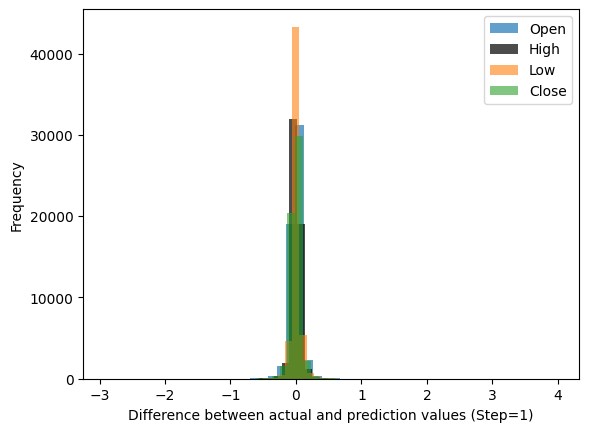

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference between actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

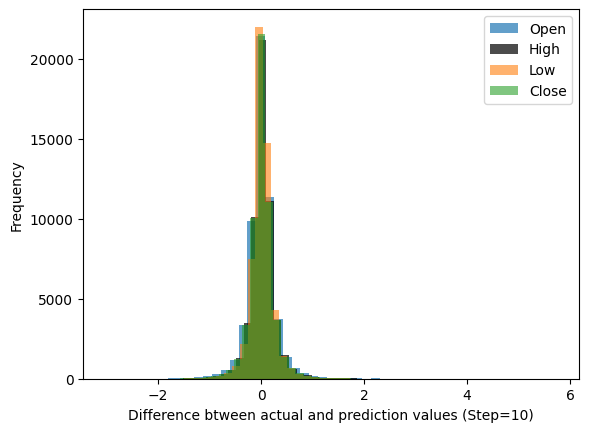

In [47]:
import matplotlib.pyplot as plt

step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [48]:
diff_array = ohlc_pre[1:] - ohlc_ans[1:]
columns = ["open", "high", "low", "close"]
mean_df = pd.DataFrame(np.mean(diff_array, axis=1), columns=columns)
var_df = pd.DataFrame(np.var(diff_array, axis=1), columns=columns)

print(mean_df)
print(var_df)

       open      high       low     close
0  0.000878  0.003494  0.001589  0.001789
1  0.001757  0.006989  0.003183  0.003586
2  0.002646  0.010499  0.004785  0.005395
3  0.003548  0.014015  0.006394  0.007209
4  0.004456  0.017535  0.008004  0.009020
5  0.005361  0.021053  0.009613  0.010833
6  0.006267  0.024571  0.011222  0.012644
7  0.007172  0.028087  0.012830  0.014453
8  0.008075  0.031599  0.014438  0.016259
9  0.008973  0.035111  0.016043  0.018067
       open      high       low     close
0  0.009897  0.006269  0.006157  0.007645
1  0.019840  0.013943  0.013135  0.015383
2  0.030097  0.021543  0.019849  0.023397
3  0.039920  0.029239  0.026235  0.031064
4  0.049828  0.036900  0.032416  0.038792
5  0.059530  0.044557  0.038497  0.046330
6  0.069445  0.052065  0.044638  0.054001
7  0.079510  0.059773  0.050915  0.061851
8  0.089619  0.067547  0.057108  0.069746
9  0.099695  0.075150  0.063410  0.077641


[]

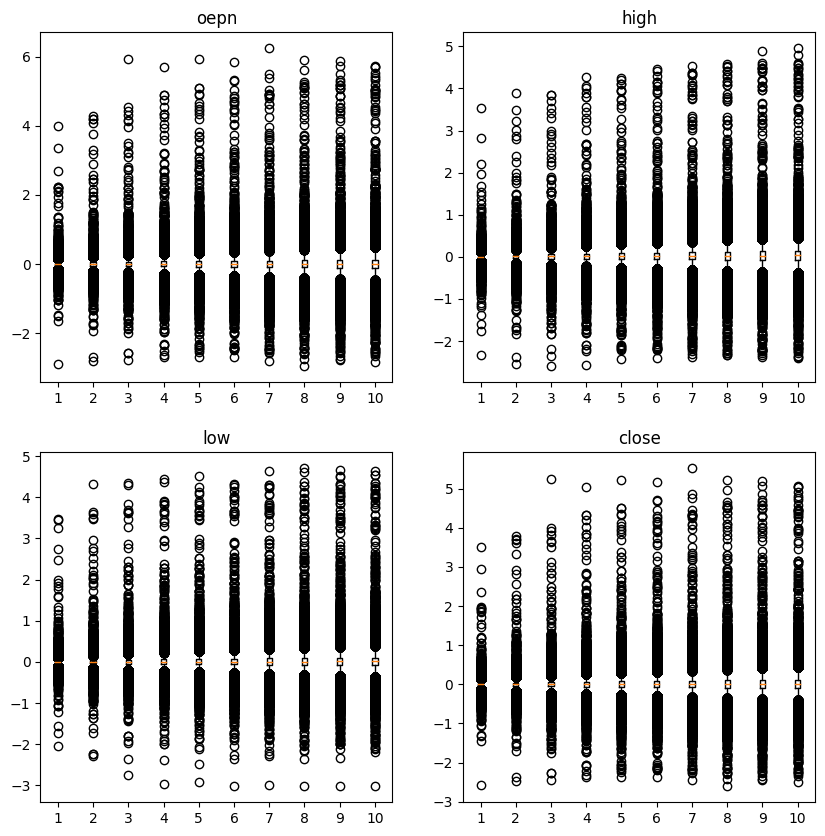

In [49]:
quant_1_df = pd.DataFrame(np.quantile(diff_array, 0.25, axis=1), columns=columns)
quant_2_df = pd.DataFrame(np.quantile(diff_array, 0.5, axis=1), columns=columns)
quant_3_df = pd.DataFrame(np.quantile(diff_array, 0.75, axis=1), columns=columns)
min_df = pd.DataFrame(np.min(diff_array, axis=1), columns=columns)
max_df = pd.DataFrame(np.max(diff_array, axis=1), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for index in range(0, 10):
  axs[0,0].boxplot(diff_array[index, :, 0], positions=[index+1])
  axs[0,1].boxplot(diff_array[index, :, 1], positions=[index+1])
  axs[1,0].boxplot(diff_array[index, :, 2], positions=[index+1])
  axs[1,1].boxplot(diff_array[index, :, 3], positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

[]

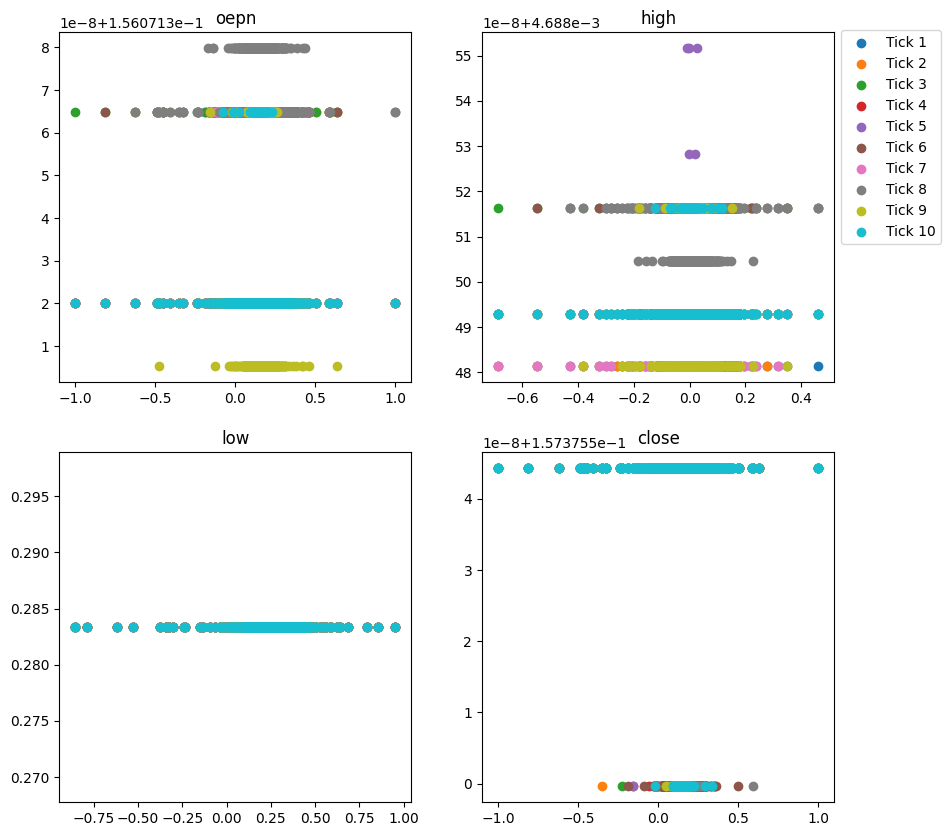

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for step in range(1, 11):

  axs[0,0].scatter(ohlc_ans_org[step, :, 0], ohlc_pre_org[step, :, 0], label=f'Tick {step}')
  axs[0,1].scatter(ohlc_ans_org[step, :, 1], ohlc_pre_org[step, :, 1], label=f'Tick {step}')
  axs[1,0].scatter(ohlc_ans_org[step, :, 2], ohlc_pre_org[step, :, 2], label=f'Tick {step}')
  axs[1,1].scatter(ohlc_ans_org[step, :, 3], ohlc_pre_org[step, :, 3], label=f'Tick {step}')
axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

In [51]:
diff_array_org = ohlc_pre_org[1:] - ohlc_ans_org[1:]
mean_org_df = pd.DataFrame(np.mean(diff_array_org, axis=1), columns=["open", "high", "low", "close"])
var_org_df = pd.DataFrame(np.var(diff_array_org, axis=1), columns=["open", "high", "low", "close"])

print(mean_org_df)
print(var_org_df)

       open      high       low     close
0  0.000255  0.000686  0.000523  0.000588
1  0.000255  0.000687  0.000525  0.000591
2  0.000258  0.000690  0.000527  0.000595
3  0.000262  0.000691  0.000530  0.000596
4  0.000264  0.000692  0.000530  0.000596
5  0.000263  0.000691  0.000530  0.000596
6  0.000263  0.000691  0.000530  0.000595
7  0.000263  0.000691  0.000529  0.000595
8  0.000262  0.000690  0.000529  0.000594
9  0.000261  0.000690  0.000529  0.000594
       open      high       low     close
0  0.000835  0.000242  0.000667  0.000826
1  0.000835  0.000242  0.000667  0.000827
2  0.000835  0.000242  0.000667  0.000827
3  0.000835  0.000242  0.000667  0.000827
4  0.000835  0.000242  0.000667  0.000827
5  0.000835  0.000242  0.000667  0.000827
6  0.000835  0.000242  0.000667  0.000827
7  0.000835  0.000242  0.000667  0.000827
8  0.000835  0.000242  0.000667  0.000827
9  0.000835  0.000242  0.000667  0.000827


[]

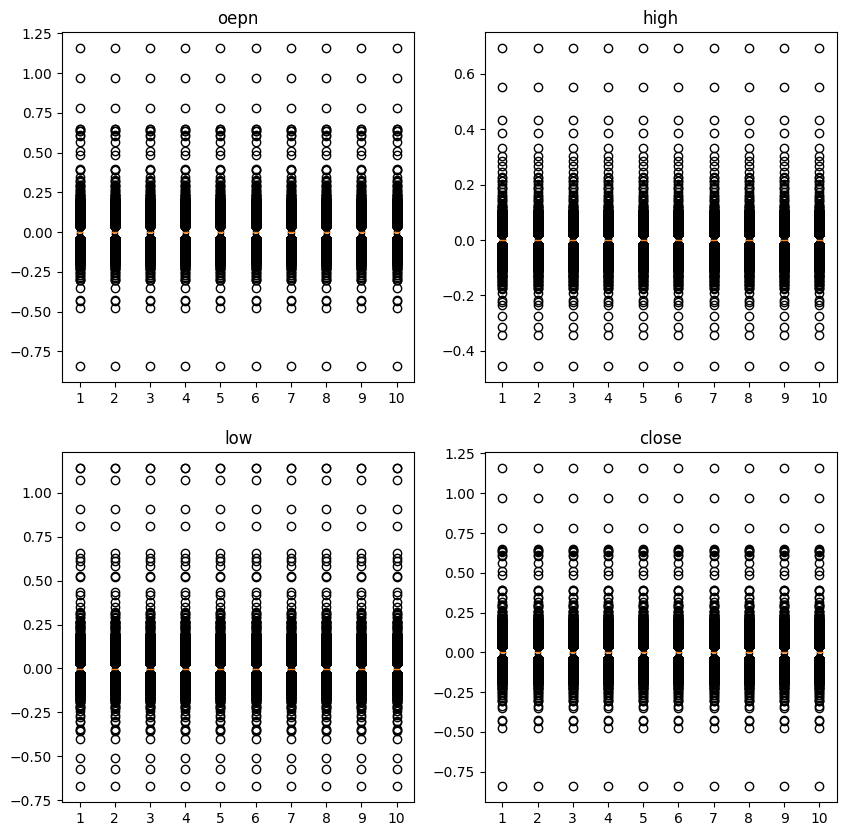

In [52]:
quant_1_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.25, axis=1), columns=columns)
quant_2_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.5, axis=1), columns=columns)
quant_3_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.75, axis=1), columns=columns)
min_org_df = pd.DataFrame(np.min(diff_array_org, axis=1), columns=columns)
max_org_df = pd.DataFrame(np.max(diff_array_org, axis=1), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for index in range(0, 10):
  axs[0,0].boxplot(diff_array_org[index, :, 0], positions=[index+1])
  axs[0,1].boxplot(diff_array_org[index, :, 1], positions=[index+1])
  axs[1,0].boxplot(diff_array_org[index, :, 2], positions=[index+1])
  axs[1,1].boxplot(diff_array_org[index, :, 3], positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

In [53]:
validation_file_path = f'{data_folder}/{model_name}/{model_name}_v{model_version}_validation.csv'
validation_df = pd.concat([
    mean_df, var_df, quant_1_df, quant_2_df, quant_3_df, min_df, max_df,
    mean_org_df, var_org_df, quant_1_org_df, quant_2_org_df, quant_3_org_df, min_org_df, max_org_df,
    ],
    keys=[
        "mean", "var", "q1", "q2", "q3", "min", "max",
        "org_mean", "org_var", "org_q1", "org_q2", "org_q3", "org_min", "org_max"
        ],
    axis=1)
validation_df.to_csv(validation_file_path)
if storage_handler is not None:
    destination_file_path = f'/{model_name}/{model_name}_v{model_version}_validation.csv'
    storage_handler.upload_file(validation_file_path, destination_file_path)

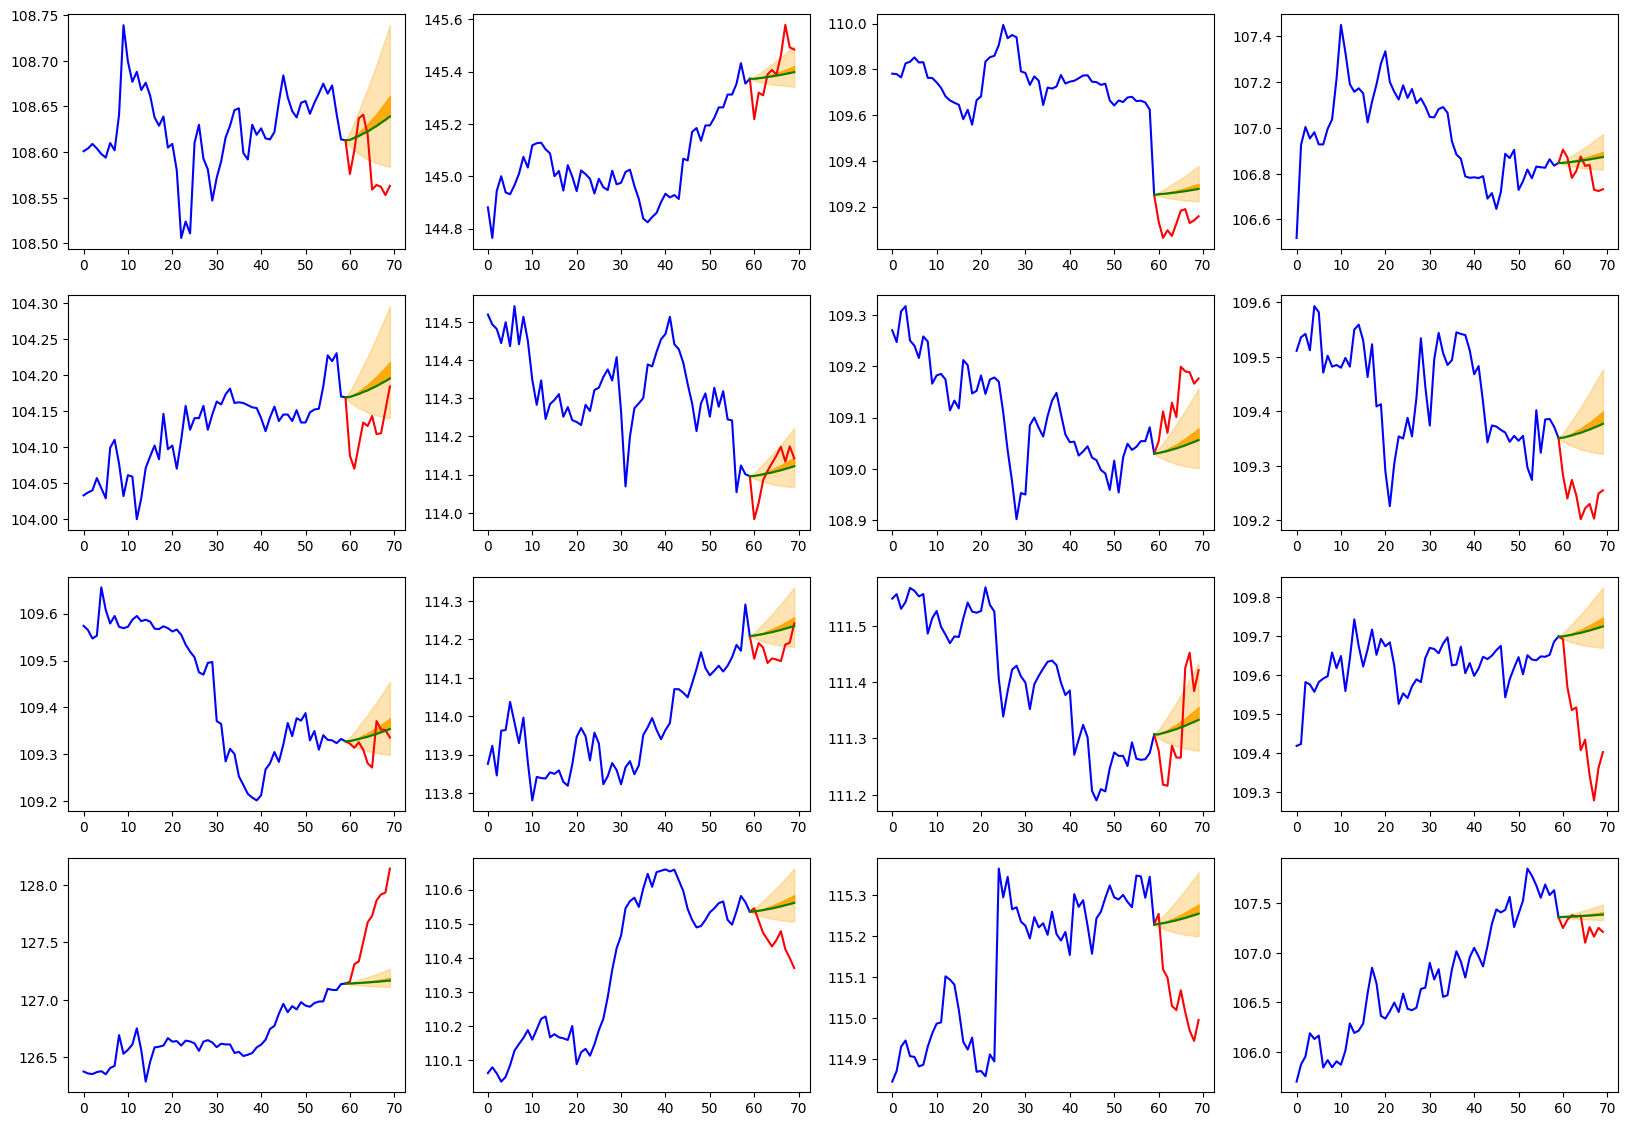

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)

for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[3]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 3], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

### Summary

In [32]:
model_name = "finance_basic_transformer_ext"
model_versions = [1, 2, 3, 4]

for model_version in model_versions:
  destination_path = f"/{model_name}/{model_name}_v{model_version}.csv"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}.csv"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}.csv was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}.csv")

  destination_path = f"/{model_name}/{model_name}_v{model_version}_params.json"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}_params.json"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}_params.json was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}_params.json")

  destination_path = f"/{model_name}/{model_name}_v{model_version}_validation.csv"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}_validation.csv"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}_validation.csv was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}_validation.csv")

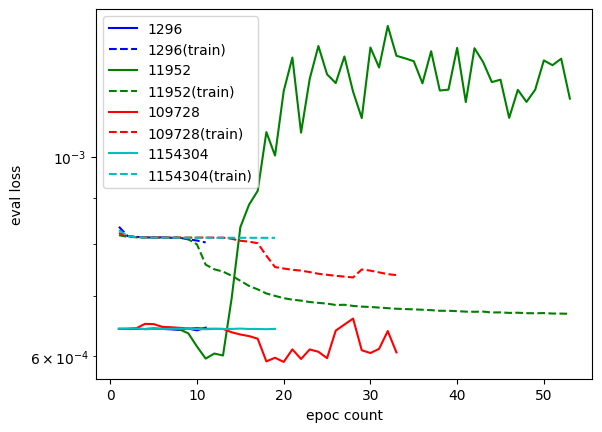

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
logs_files = glob.glob(f"{data_folder}/{model_name}/{model_name}*_params.json")
logs_files.sort()

eval_loss = []
train_loss = []
eval_params = []

for index, log_file in enumerate(logs_files):
    color_index = index % len(colors)
    with open(log_file) as fp:
        params = json.load(fp)
    params_num = params["params_num"]
    log_file = log_file.replace("_params.json", ".csv")
    logs = pd.read_csv(log_file, header=None)
    logs = logs.iloc[1:]
    logs.columns = ["time","train_loss", "eval_loss"]
    eval_params.append(params_num)
    eval_loss.append(logs.eval_loss.min())
    train_loss.append(logs.train_loss.min())
    plt.yscale("log")
    plt.plot([*logs.index], logs.eval_loss, label=params_num, color=colors[color_index])
    plt.plot([*logs.index], logs.train_loss, label=f"{params_num}(train)", linestyle='--', color=colors[color_index])
plt.xlabel("epoc count")
plt.ylabel("eval loss")
plt.legend()
plt.show()

[]

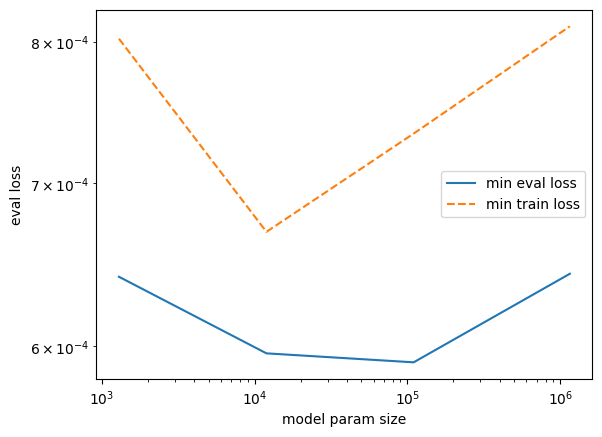

In [37]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("model param size")
plt.ylabel("eval loss")
plt.plot(eval_params, eval_loss, label="min eval loss")
plt.plot(eval_params, train_loss, linestyle="--", label="min train loss")
plt.legend()
plt.plot()

## Summary

Increasing Data a bit improve the eval loss. But model size is irrelevant (or even minimum model size is too large).


In [38]:
model_base_name = "finance_basic_transformer"
variants = ["", "ext"]
variant_files = {}
model_versions = [1, 2, 3, 4]

for variant in variants:
  if variant != "":
    model_name = f"{model_base_name}_{variant}"
  else:
    model_name = model_base_name
  variant_files[variant] = {}

  for model_version in model_versions:
    variant_files[variant][model_version] = {}

    destination_path = f"/{model_name}/{model_name}_v{model_version}.csv"
    local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}.csv"
    if os.path.exists(local_path):
      variant_files[variant][model_version]["log"] = local_path
    else:
      response = storage_handler.download_file(destination_path, local_path)
      if response is not None:
        print(f"{model_name}_v{model_version}.csv was downloaded")
        variant_files[variant][model_version]["log"] = local_path
      else:
        print(f"failed to download {model_name}_v{model_version}.csv")

    destination_path = f"/{model_name}/{model_name}_v{model_version}_params.json"
    local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}_params.json"
    if os.path.exists(local_path):
      variant_files[variant][model_version]["params"] = local_path
    else:
      response = storage_handler.download_file(destination_path, local_path)
      if response is not None:
        print(f"{model_name}_v{model_version}_params.json was downloaded")
        variant_files[variant][model_version]["params"] = local_path
      else:
        print(f"failed to download {model_name}_v{model_version}_params.json")

    destination_path = f"/{model_name}/{model_name}_v{model_version}_validation.csv"
    local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}_validation.csv"
    if os.path.exists(local_path):
      variant_files[variant][model_version]["val"] = local_path
    else:
      response = storage_handler.download_file(destination_path, local_path)
      if response is not None:
        print(f"{model_name}_v{model_version}_validation.csv was downloaded")
        variant_files[variant][model_version]["val"] = local_path
      else:
        print(f"failed to download {model_name}_v{model_version}_validation.csv")

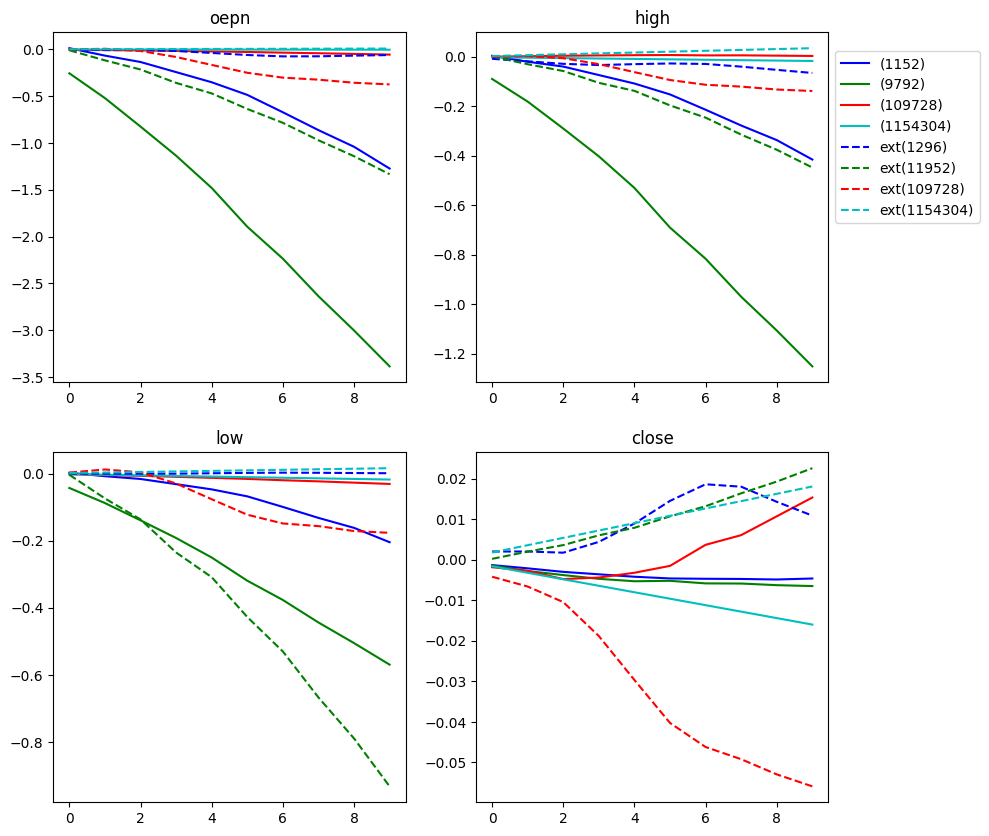

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import json

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

line_styles = ["-", "--"]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

line_index = -1
for variant, versions in variant_files.items():
  color_index = -1
  line_index += 1
  for version, files in versions.items():
    color_index += 1
    param_file = files["params"]
    validation_file = files["val"]
    with open(param_file, "r") as fp:
      params = json.load(fp)
    model_params = params["params_num"]
    validation_result =  pd.read_csv(validation_file, header=[0, 1], index_col=0)

    axs[0,0].plot(validation_result["mean"]["open"], color=colors[color_index], linestyle = line_styles[line_index], label=f"{variant}({model_params})")
    axs[0,1].plot(validation_result["mean"]["high"], color=colors[color_index], linestyle = line_styles[line_index], label=f"{variant}({model_params})")
    axs[1,0].plot(validation_result["mean"]["low"], color=colors[color_index], linestyle = line_styles[line_index], label=f"{variant}({model_params})")
    axs[1,1].plot(validation_result["mean"]["close"], color=colors[color_index], linestyle = line_styles[line_index], label=f"{variant}({model_params})")

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
# plt.xlabel("predition step")
# plt.ylabel("prediction - answer")
plt.show()

In [40]:
best_models = {}
for variant, versions in variant_files.items():
  best_models[variant] = None
  min_eval_loss = np.inf
  for version, files in versions.items():
    log_file = files["log"]
    logs = pd.read_csv(log_file, header=None)
    logs.columns = ["time","train_loss", "eval_loss"]
    eval_loss = logs.eval_loss.min()
    if min_eval_loss > eval_loss:
      min_eval_loss = eval_loss
      best_models[variant] = files

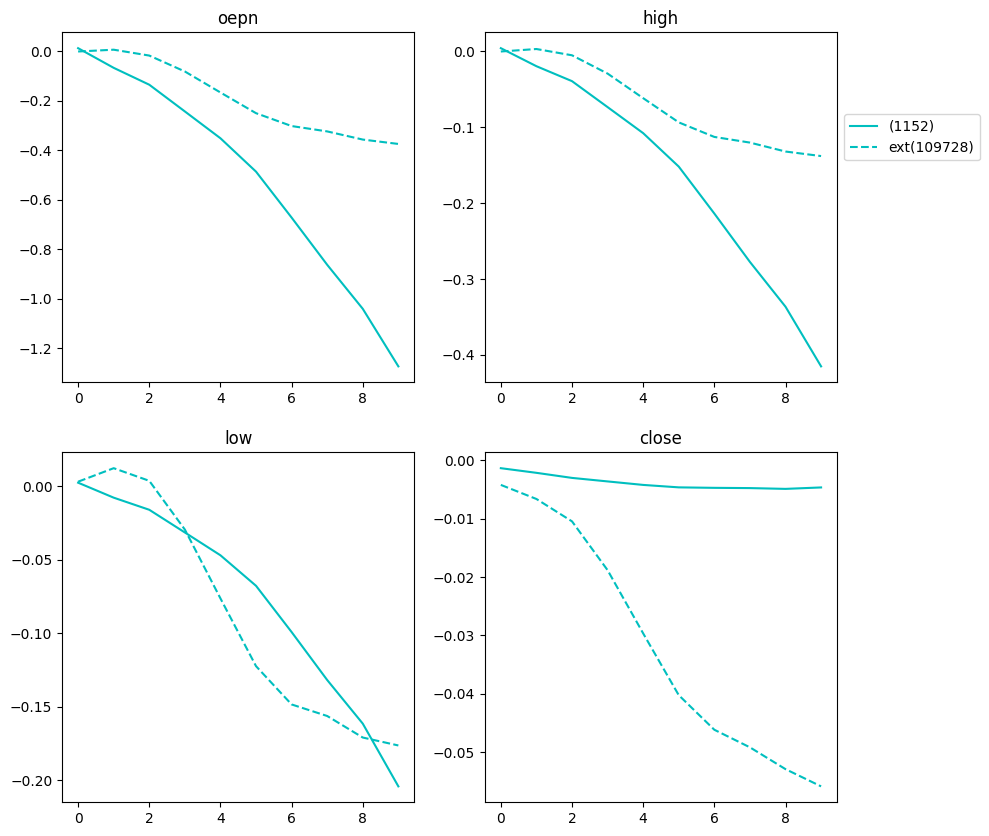

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import json

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

line_styles = ["-", "--"]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

line_index = -1
for variant, files in best_models.items():
  line_index += 1
  param_file = files["params"]
  validation_file = files["val"]
  with open(param_file, "r") as fp:
    params = json.load(fp)
  model_params = params["params_num"]
  validation_result =  pd.read_csv(validation_file, header=[0, 1], index_col=0)

  axs[0,0].plot(validation_result["mean"]["open"], color=colors[color_index], linestyle = line_styles[line_index], label=f"{variant}({model_params})")
  axs[0,1].plot(validation_result["mean"]["high"], color=colors[color_index], linestyle = line_styles[line_index], label=f"{variant}({model_params})")
  axs[1,0].plot(validation_result["mean"]["low"], color=colors[color_index], linestyle = line_styles[line_index], label=f"{variant}({model_params})")
  axs[1,1].plot(validation_result["mean"]["close"], color=colors[color_index], linestyle = line_styles[line_index], label=f"{variant}({model_params})")

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.show()

[]

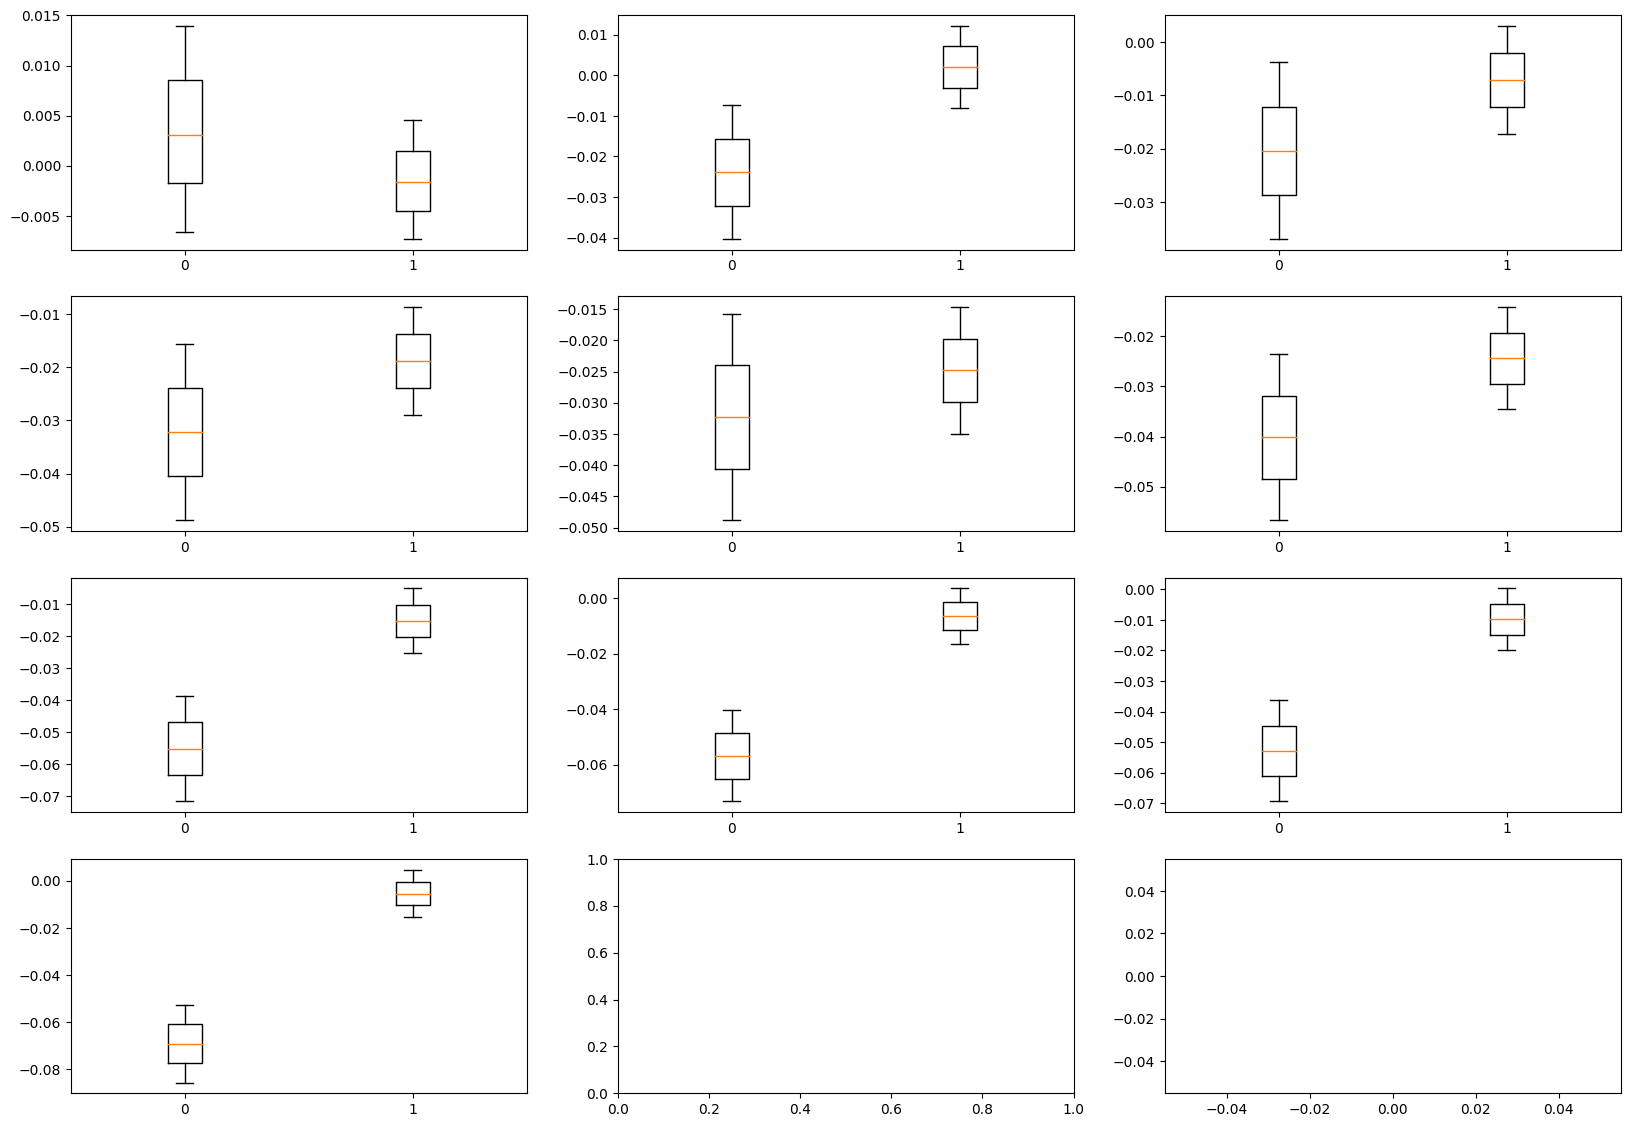

In [44]:
fig, axs = plt.subplots(4, 3, figsize=(20, 14))

position_index = -1
for variant, files in best_models.items():
  position_index += 1
  file = files["val"]
  validation_df = pd.read_csv(file, header=[0, 1], index_col=0)
  validation_df.columns = validation_df.columns.swaplevel(0, 1)

  quantile_df = validation_df["open"][["org_q1", "org_q2", "org_q3"]]
  for index in range(0, 10):
    x_index = index // 3
    y_index = index % 3
    axs[x_index, y_index].boxplot([quantile_df.iloc[index].values], positions=[position_index])
plt.plot()

[]

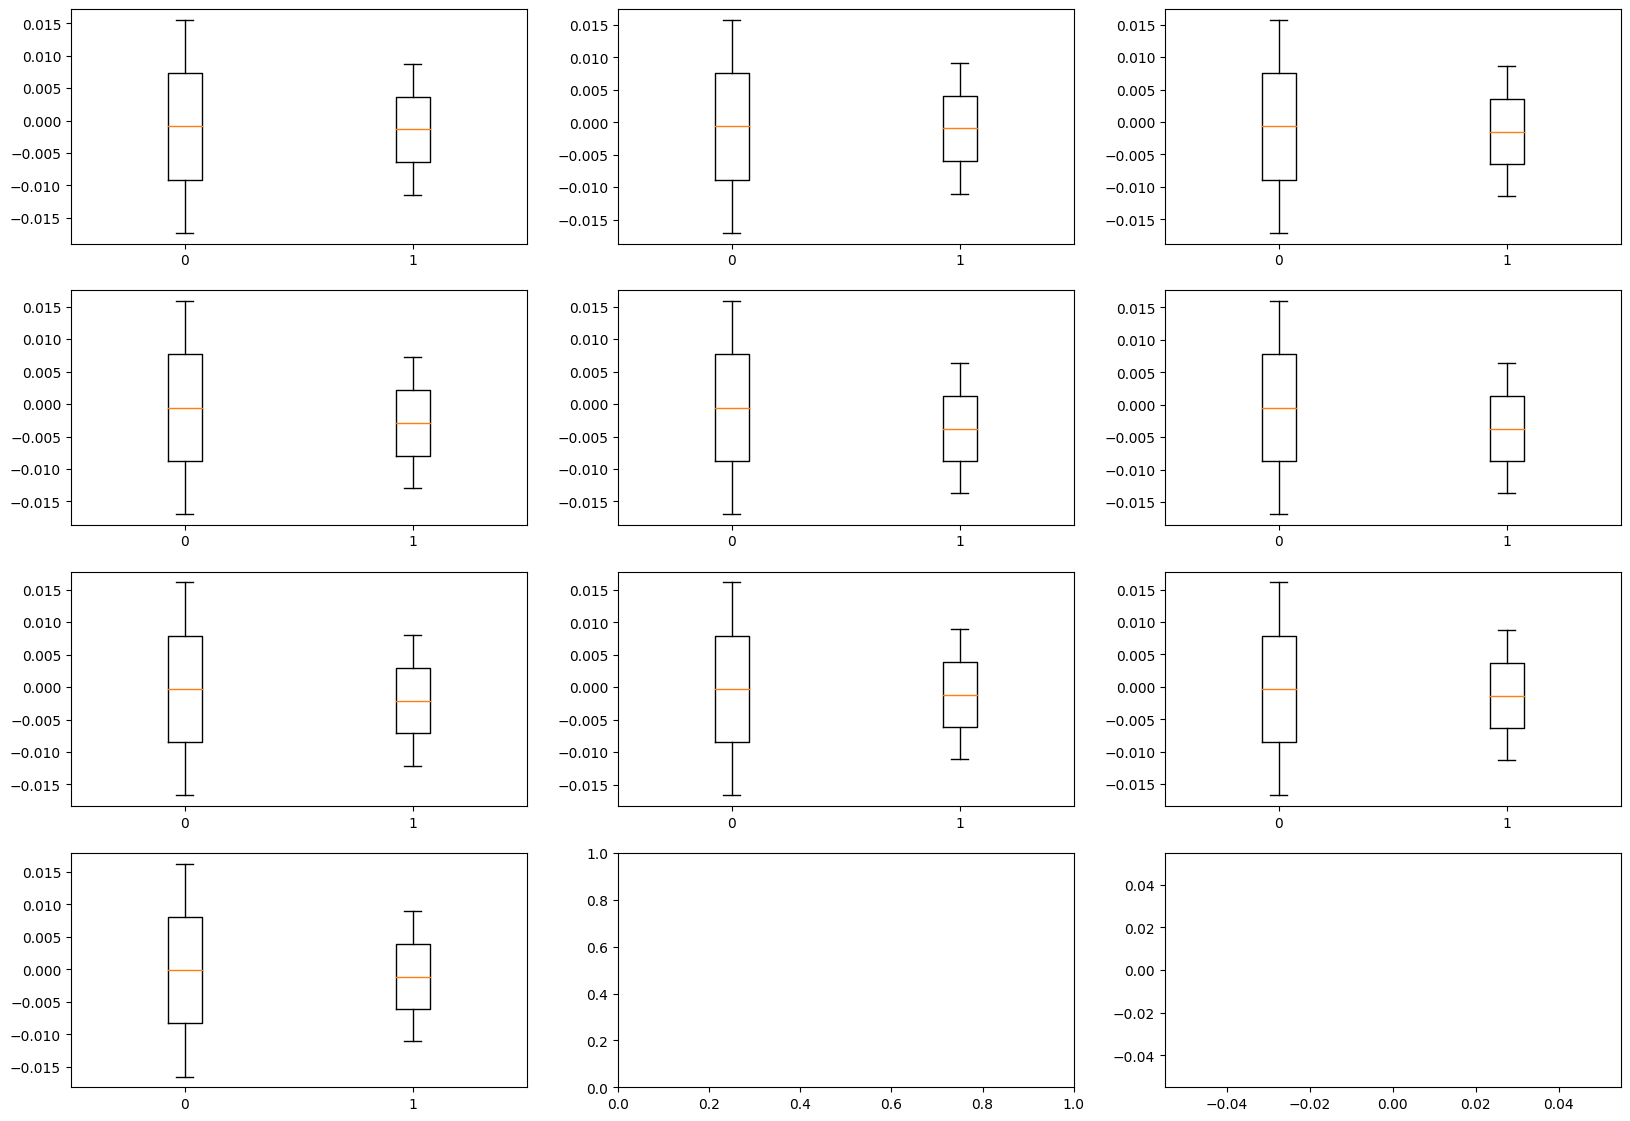

In [43]:
fig, axs = plt.subplots(4, 3, figsize=(20, 14))

position_index = -1
for variant, files in best_models.items():
  position_index += 1
  file = files["val"]
  validation_df = pd.read_csv(file, header=[0, 1], index_col=0)
  validation_df.columns = validation_df.columns.swaplevel(0, 1)

  quantile_df = validation_df["close"][["org_q1", "org_q2", "org_q3"]]
  for index in range(0, 10):
    x_index = index // 3
    y_index = index % 3
    axs[x_index, y_index].boxplot([quantile_df.iloc[index].values], positions=[position_index])
plt.plot()

# BaseLine Transformer model with Weekly Time Position

Above results seems that predictions didn't learn the position. Not sure if that caused by scale difference or lack of features.
Next model investigate it by changing positioning encoder from sin/cos of vector position to weekky hour position.
For example, if the steps is observed on [Monday 23:00, Monday 23:30, Thuesday 00:00, Thuesday 00:00], makes it as [47, 48, 49, 50] to represents the position of the step in the week. Then convert it to Embedded vector to add it to src and tgt.

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return position

In [10]:
class Seq2SeqTransformer(nn.Module):

    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int, time_size:int =  24*7*2,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):

        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(time_size=time_size, d_model=feature_size)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self,
        src: Tensor, src_time: Tensor,
        tgt: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):

        src_time = self.positional_encoding(src_time)
        src = self.dropout(torch.add(src, src_time))
        tgt_time = self.positional_encoding(tgt_time)
        tgt = self.dropout(torch.add(tgt, tgt_time))
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

In [11]:
def train(model, ds, optimizer, criterion, batch_size, device):

    model.train()
    ds.train()
    losses = 0

    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / length

In [12]:
def evaluate(model, ds, criterion, batch_size, device):

    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()

    return losses / length

In [13]:
def create_model(nhead, dim_feedforward, num_encoder_layers, num_decoder_layers, dropout, feature_size=4, freq=30, **kwargs):
  time_size = 24*7*(60//freq)

  model = Seq2SeqTransformer(
      num_encoder_layers=num_encoder_layers,
      num_decoder_layers=num_decoder_layers,
      feature_size=feature_size,
      time_size=time_size,
      dim_feedforward=dim_feedforward,
      dropout=dropout, nhead=nhead
  )
  return model

### Row Data

In [14]:
import os
import pandas as pd

ohlc_column = ['open','high','low','close']
file_name = "mt5_USDJPY_min30.zip"

file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df

open     high      low    close  tick_volume  spread  \
time                                                                           
2014-07-07 08:30:00  102.086  102.122  102.081  102.102          738       3   
2014-07-07 09:00:00  102.102  102.146  102.098  102.113         1036       3   
2014-07-07 09:30:00  102.113  102.115  102.042  102.044          865       3   
2014-07-07 10:00:00  102.047  102.052  102.005  102.019          983       3   
2014-07-07 10:30:00  102.017  102.025  101.918  101.941         1328       3   
...                      ...      ...      ...      ...          ...     ...   
2022-08-12 21:30:00  133.461  133.506  133.439  133.484         1125       3   
2022-08-12 22:00:00  133.484  133.530  133.437  133.475         1277       3   
2022-08-12 22:30:00  133.475  133.486  133.433  133.483         1506       3   
2022-08-12 23:00:00  133.484  133.536  133.465  133.521         1038       3   
2022-08-12 23:30:00  133.521  133.522  133.301  133.313         2515       3   

                     real_volume  
time                              
2014-07-07 08:30:00            0  
2014-07-07 09:00:00            0  
2014-07-07 09:30:00            0  
2014-07-07 10:00:00            0  
2014-07-07 10:30:00            0  
...                          ...  
2022-08-12 21:30:00            0  
2022-08-12 22:00:00            0  
2022-08-12 22:30:00            0  
2022-08-12 23:00:00            0  
2022-08-12 23:30:00            0  

[100720 rows x 7 columns]

In [15]:
ohlc_column = ['open','high','low','close']
freq=30
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq=freq, time_column= "index")
#ohlc_pre_process = [log_p, diff_p, time_p]
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [16]:
from Dataset.transformer import TimeFeatureDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_wt_transformer"

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, index_sampler="k_fold", device=device)

In [17]:
# check outputs represent (data_length, chunk_size, feature_size)
ds.train()
for index in range(0, len(ds)-16, 16):
    src, tgt = ds[index: index+16]
    break
print(src[0].shape, src[1].shape)
print(tgt[0].shape, tgt[1].shape)

torch.Size([60, 16, 4]) torch.Size([60, 16])
torch.Size([11, 16, 4]) torch.Size([11, 16])


#### Training

In [25]:
model_version = "1"
model_params, model, optimizer, scheduler = load_model(model_name, model_version, device, True, storage_handler=storage_handler,
                                 optimizer_class=torch.optim.Adam,
                                 scheduler_class=torch.optim.lr_scheduler.StepLR)

if model is None:
    print("Initialize a new model.")

    # Hyper parameters
    model_params = {
        "nhead": 1,
        "dim_feedforward": 1,
        "num_encoder_layers": 1,
        "num_decoder_layers": 1,
        "dropout": 0.1
    }

    model = create_model(
        feature_size=feature_size,
        **model_params
    ).to(device)

params_num = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params_num += p.numel()
print(f"params: {params_num}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


params: 11136


In [26]:
lr = 0.0005

criterion = nn.MSELoss()
if optimizer is None:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [27]:
logger = Logger(model_name, model_version, base_folder, storage_handler=storage_handler)

start_index, end_index = ds.get_date_range()
params = {"processes": fprocess.preprocess_to_params(processes),
          "source": {
              "path": file_path,
              "start": start_index.isoformat(),
              "end": end_index.isoformat(),
              "length": len(ds)
          },
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          **model_params,
          "params_num": params_num,
          "version": 2
}

logger.save_params(params, model_name, model_version)

print("training log will be saved on ", logger.log_file_path)

training log will be saved on  /content/drive/My Drive/Data/finance_basic_wt_transformer_ext/finance_basic_wt_transformer_ext_v2.csv


In [ ]:
epoch = 500
best_train_loss, best_valid_loss = logger.get_min_losses()
best_model = None
best_train_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):

    start_time = time.time()

    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )

    elapsed_time = time.time() - start_time

    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )

    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_valid_loss > loss_valid else ''
    )
    print(log)
    logger.add_training_log(loss_train, loss_valid, elapsed_time)

    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
          logger.save_checkpoint(best_train_model, optimizer, scheduler, f'{model_name}_train', model_version)
        scheduler.step()
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        logger.save_checkpoint(best_model, optimizer, scheduler, model_name, model_version)

    if counter > patience:
        break
    
logger.save_checkpoint(best_model, optimizer, scheduler, f'{model_name}_train', model_version)
logger.save_checkpoint(best_model, optimizer, scheduler, model_name, model_version)

#### Validation

In [114]:
model_name = "finance_basic_wt_transformer"
model_version = 4
feature_size = 4

_, model = load_model(model_name, model_version, device, False, storage_handler=storage_handler)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [61]:
def prediction(inputs, tgt_time_org):
    inputs, src_time = inputs
    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    # instead of caliculate next tick time, use tgt_time provided by dataset
    tgt_time = tgt_time_org[:1, :]
    while preds.size(0) <= prediction_length:
        current_length = preds.size(0)
        tgt_time = tgt_time_org[:current_length, :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, src_time=src_time,
                    tgt=preds, tgt_time=tgt_time,
                    mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [ ]:
src, tgt = ds[:16]

pred_sample = prediction(src, tgt[1])
pred_sample[:, 0, :]

In [ ]:
from Dataset import revert_process

src_values = src[0].cpu().detach().numpy()
r_data = revert_process.revert(ds, src_values, [index for index in range(0, 16)], is_tgt=False)
r_data[:, 0, :]

In [115]:
from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 1000
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))

    preds = prediction(val_inp, val_ans[1])
    pre_values = preds.cpu().detach().numpy()

    ohlc = revert_process.revert(ds, pre_values, ndx, True, columns=ohlc_column)

    if factor == 0:
        ohlc_pre = ohlc
        ohlc_pre_org = pre_values
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
        ohlc_pre_org = np.append(ohlc_pre_org, pre_values, axis=1)

    ans_values = val_ans[0].cpu().detach().numpy()

    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True, columns=ohlc_column)

    if factor == 0:
        ohlc_ans = temp_ohlc
        ohlc_ans_org = ans_values
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)
        ohlc_ans_org = np.append(ohlc_ans_org, ans_values, axis=1)

[]

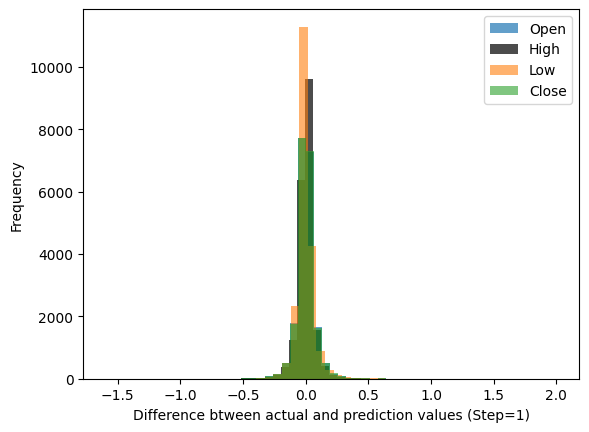

In [117]:
import matplotlib.pyplot as plt
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

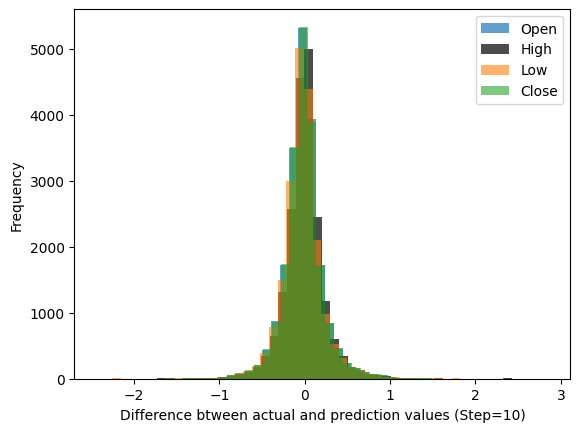

In [118]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [119]:
diff_array = ohlc_pre[1:] - ohlc_ans[1:]
columns = ["open", "high", "low", "close"]
mean_df = pd.DataFrame(np.mean(diff_array, axis=1), columns=columns)
var_df = pd.DataFrame(np.var(diff_array, axis=1), columns=columns)

print(mean_df)
print(var_df)

       open      high       low     close
0 -0.001807 -0.000459 -0.002767 -0.001190
1 -0.003612 -0.000916 -0.005533 -0.002379
2 -0.005417 -0.001373 -0.008300 -0.003571
3 -0.007223 -0.001828 -0.011065 -0.004755
4 -0.009023 -0.002278 -0.013827 -0.005938
5 -0.010821 -0.002727 -0.016586 -0.007119
6 -0.012617 -0.003176 -0.019348 -0.008303
7 -0.014418 -0.003626 -0.022111 -0.009484
8 -0.016215 -0.004075 -0.024871 -0.010667
9 -0.018013 -0.004526 -0.027633 -0.011852
       open      high       low     close
0  0.006636  0.005319  0.006150  0.006569
1  0.012950  0.011851  0.013190  0.012873
2  0.019528  0.018534  0.020251  0.019444
3  0.025981  0.025112  0.026954  0.025895
4  0.032606  0.031738  0.033625  0.032519
5  0.039177  0.038327  0.040332  0.039088
6  0.045883  0.044882  0.047152  0.045770
7  0.052600  0.051453  0.053962  0.052497
8  0.059181  0.058098  0.060766  0.059111
9  0.065887  0.064673  0.067443  0.065811


[]

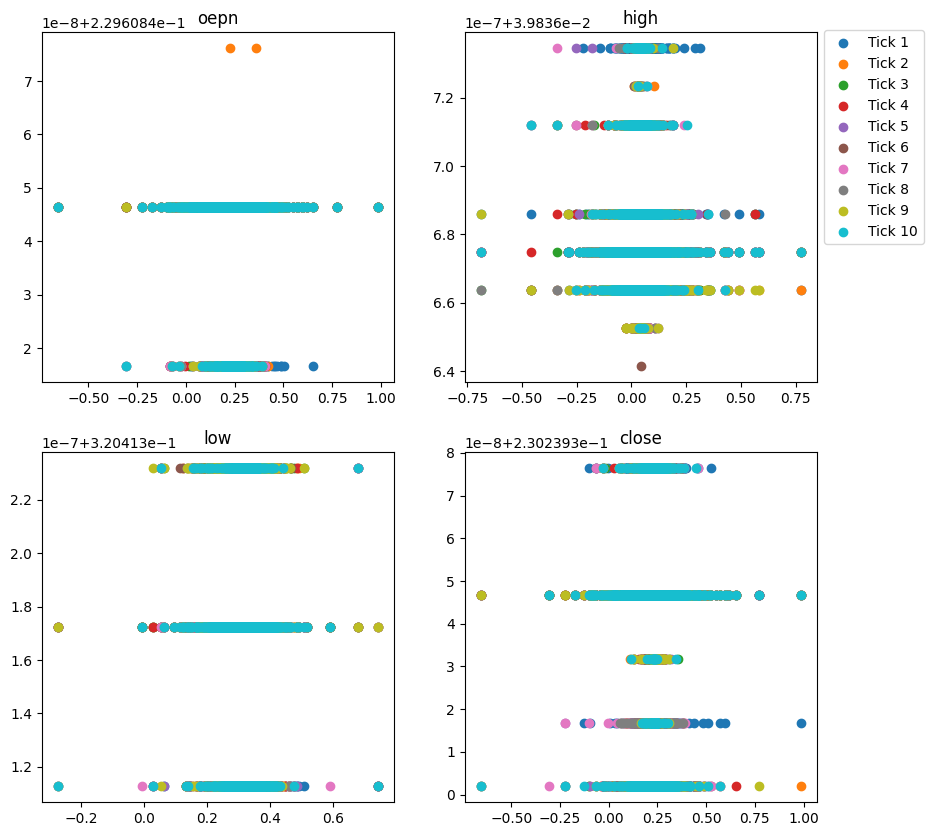

In [120]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for step in range(1, 11):

  axs[0,0].scatter(ohlc_ans_org[step, :, 0], ohlc_pre_org[step, :, 0], label=f'Tick {step}')
  axs[0,1].scatter(ohlc_ans_org[step, :, 1], ohlc_pre_org[step, :, 1], label=f'Tick {step}')
  axs[1,0].scatter(ohlc_ans_org[step, :, 2], ohlc_pre_org[step, :, 2], label=f'Tick {step}')
  axs[1,1].scatter(ohlc_ans_org[step, :, 3], ohlc_pre_org[step, :, 3], label=f'Tick {step}')
axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

[]

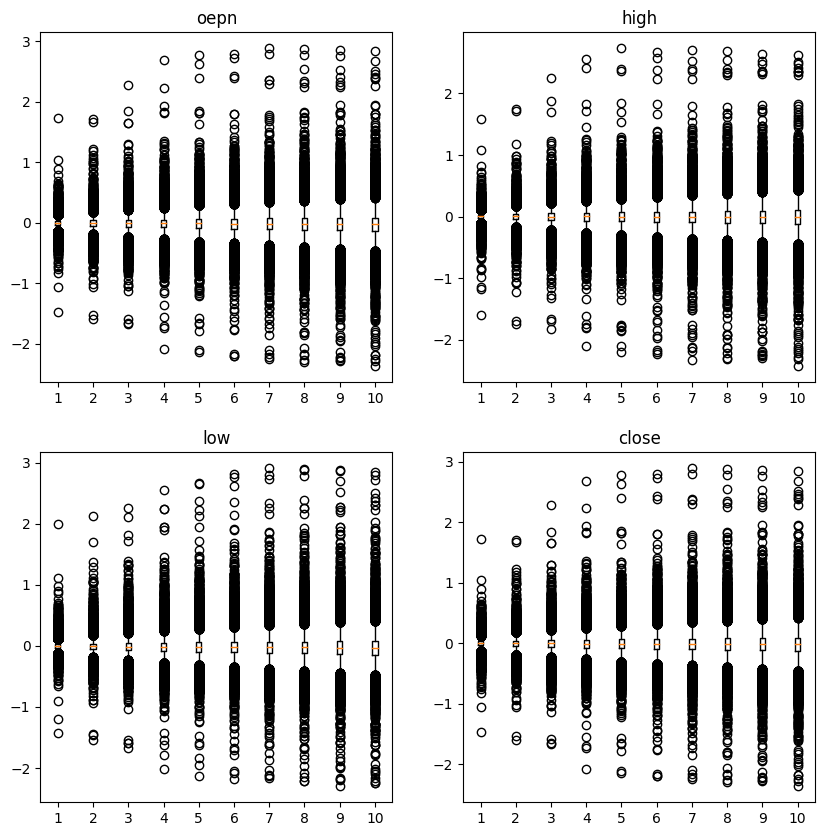

In [121]:
quant_1_df = pd.DataFrame(np.quantile(diff_array, 0.25, axis=1), columns=columns)
quant_2_df = pd.DataFrame(np.quantile(diff_array, 0.5, axis=1), columns=columns)
quant_3_df = pd.DataFrame(np.quantile(diff_array, 0.75, axis=1), columns=columns)
min_df = pd.DataFrame(np.min(diff_array, axis=1), columns=columns)
max_df = pd.DataFrame(np.max(diff_array, axis=1), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for index in range(0, 10):
  axs[0,0].boxplot(diff_array[index, :, 0], positions=[index+1])
  axs[0,1].boxplot(diff_array[index, :, 1], positions=[index+1])
  axs[1,0].boxplot(diff_array[index, :, 2], positions=[index+1])
  axs[1,1].boxplot(diff_array[index, :, 3], positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

In [122]:
diff_array_org = ohlc_pre_org[1:] - ohlc_ans_org[1:]
mean_org_df = pd.DataFrame(np.mean(diff_array_org, axis=1), columns=["open", "high", "low", "close"])
var_org_df = pd.DataFrame(np.var(diff_array_org, axis=1), columns=["open", "high", "low", "close"])

print(mean_org_df)
print(var_org_df)

       open      high       low     close
0 -0.000926 -0.000211 -0.000821 -0.000611
1 -0.000926 -0.000210 -0.000820 -0.000610
2 -0.000925 -0.000210 -0.000821 -0.000611
3 -0.000926 -0.000210 -0.000820 -0.000608
4 -0.000923 -0.000207 -0.000819 -0.000607
5 -0.000922 -0.000206 -0.000818 -0.000606
6 -0.000921 -0.000207 -0.000819 -0.000607
7 -0.000924 -0.000207 -0.000819 -0.000606
8 -0.000921 -0.000206 -0.000819 -0.000607
9 -0.000922 -0.000208 -0.000819 -0.000608
       open      high       low     close
0  0.001745  0.001126  0.000541  0.001728
1  0.001745  0.001126  0.000541  0.001728
2  0.001745  0.001126  0.000541  0.001728
3  0.001745  0.001126  0.000541  0.001729
4  0.001745  0.001126  0.000541  0.001729
5  0.001745  0.001126  0.000541  0.001729
6  0.001745  0.001126  0.000541  0.001729
7  0.001745  0.001126  0.000541  0.001729
8  0.001745  0.001126  0.000541  0.001728
9  0.001745  0.001126  0.000541  0.001729


[]

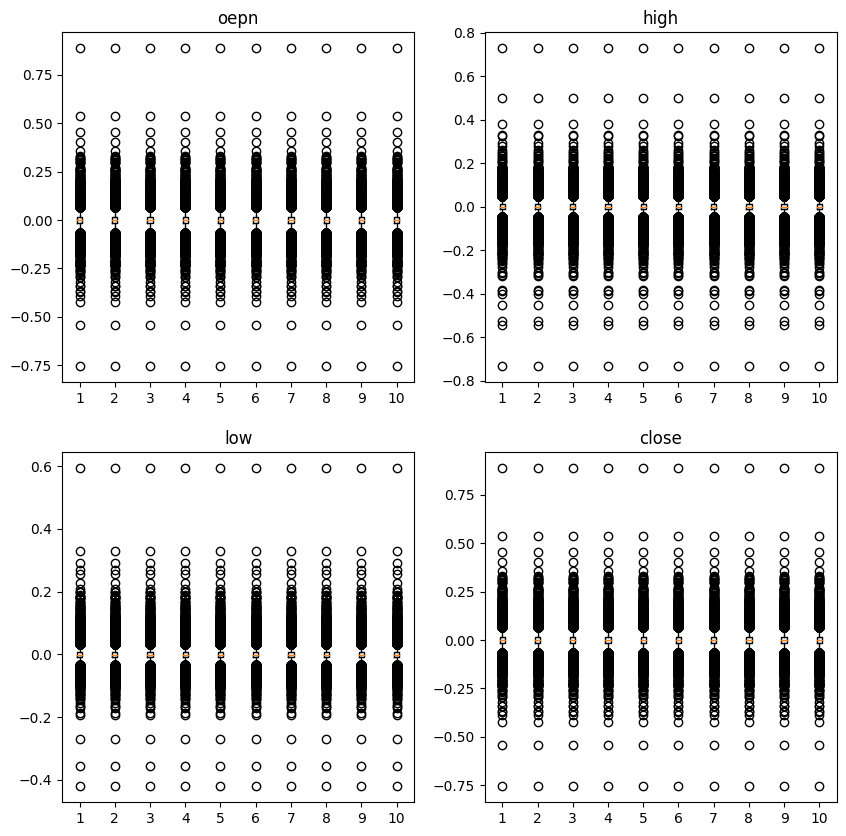

In [123]:
quant_1_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.25, axis=1), columns=columns)
quant_2_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.5, axis=1), columns=columns)
quant_3_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.75, axis=1), columns=columns)
min_org_df = pd.DataFrame(np.min(diff_array_org, axis=1), columns=columns)
max_org_df = pd.DataFrame(np.max(diff_array_org, axis=1), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for index in range(0, 10):
  axs[0,0].boxplot(diff_array_org[index, :, 0], positions=[index+1])
  axs[0,1].boxplot(diff_array_org[index, :, 1], positions=[index+1])
  axs[1,0].boxplot(diff_array_org[index, :, 2], positions=[index+1])
  axs[1,1].boxplot(diff_array_org[index, :, 3], positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

In [124]:
validation_file_path = f'{data_folder}/{model_name}/{model_name}_v{model_version}_validation.csv'
validation_df = pd.concat([
    mean_df, var_df, quant_1_df, quant_2_df, quant_3_df, min_df, max_df,
    mean_org_df, var_org_df, quant_1_org_df, quant_2_org_df, quant_3_org_df, min_org_df, max_org_df,
    ],
    keys=[
        "mean", "var", "q1", "q2", "q3", "min", "max",
        "org_mean", "org_var", "org_q1", "org_q2", "org_q3", "org_min", "org_max"
        ],
    axis=1)
validation_df.to_csv(validation_file_path)
if storage_handler is not None:
    destination_file_path = f'/{model_name}/{model_name}_v{model_version}_validation.csv'
    storage_handler.upload_file(validation_file_path, destination_file_path)

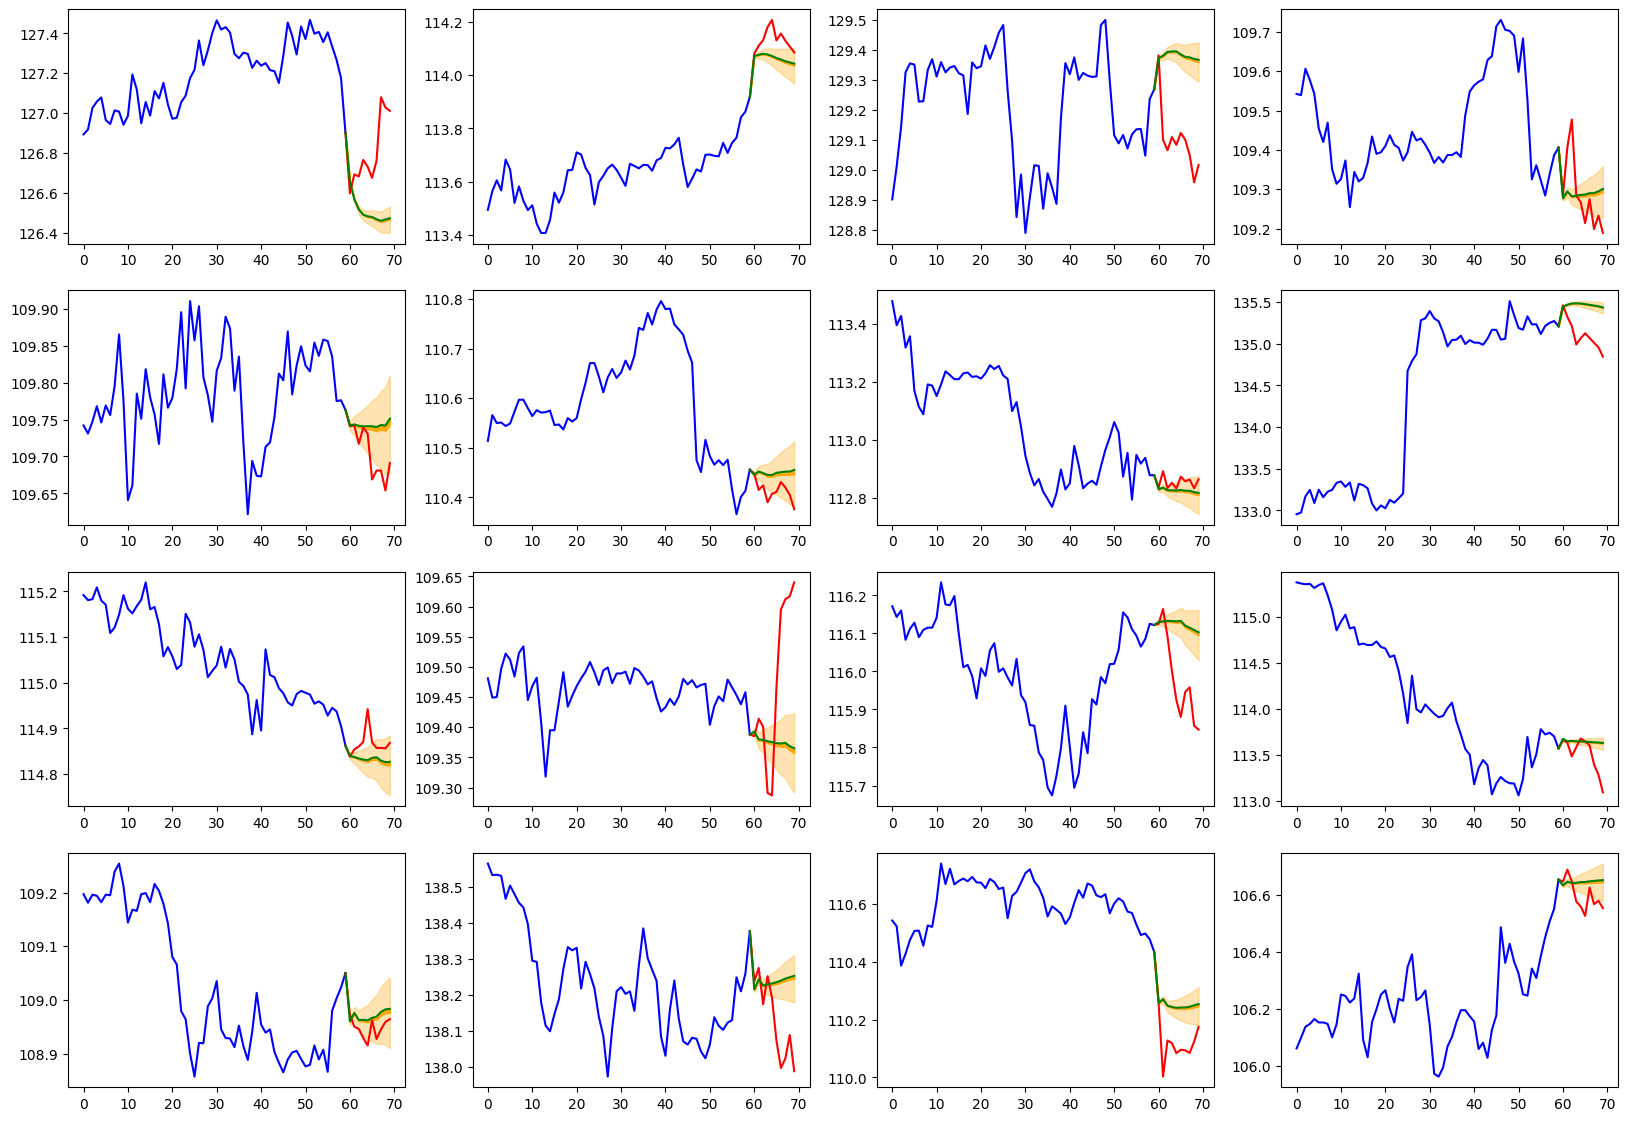

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[0]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 0]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length-1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length-1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 0], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

#### Summary

In [ ]:
model_name = "finance_basic_wt_transformer"
model_versions = [0, 1, 2, 3, 4]

for model_version in model_versions:
  destination_path = f"/{model_name}/{model_name}_v{model_version}.csv"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}.csv"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}.csv was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}.csv")

  destination_path = f"/{model_name}/{model_name}_v{model_version}_params.json"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}_params.json"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}_params.json was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}_params.json")

  destination_path = f"/{model_name}/{model_name}_v{model_version}_validation.csv"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}_validation.csv"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}_validation.csv was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}_validation.csv")

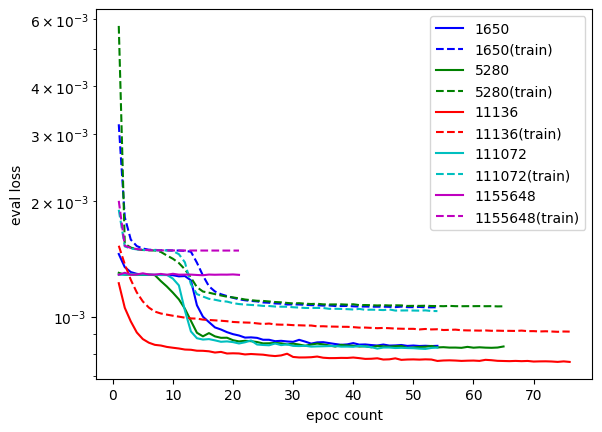

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
logs_files = glob.glob(f"{data_folder}/{model_name}/{model_name}*_params.json")
logs_files.sort()

eval_loss = []
train_loss = []
eval_params = []

for index, log_file in enumerate(logs_files):
    color_index = index % len(colors)
    with open(log_file) as fp:
        params = json.load(fp)
    params_num = params["params_num"]
    log_file = log_file.replace("_params.json", ".csv")
    logs = pd.read_csv(log_file, header=None)
    logs = logs.iloc[1:]
    logs.columns = ["time","train_loss", "eval_loss"]
    eval_params.append(params_num)
    eval_loss.append(logs.eval_loss.min())
    train_loss.append(logs.train_loss.min())
    plt.yscale("log")
    plt.plot([*logs.index], logs.eval_loss, label=params_num, color=colors[color_index])
    plt.plot([*logs.index], logs.train_loss, label=f"{params_num}(train)", linestyle='--', color=colors[color_index])
plt.xlabel("epoc count")
plt.ylabel("eval loss")
plt.legend()
plt.show()

[]

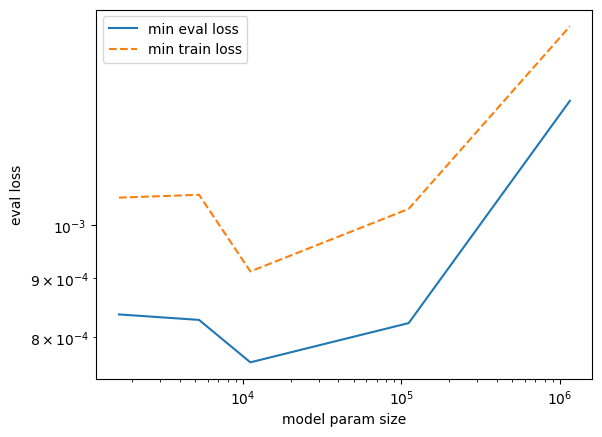

In [59]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("model param size")
plt.ylabel("eval loss")
plt.plot(eval_params, eval_loss, label="min eval loss")
plt.plot(eval_params, train_loss, linestyle="--", label="min train loss")
plt.legend()
plt.plot()

[]

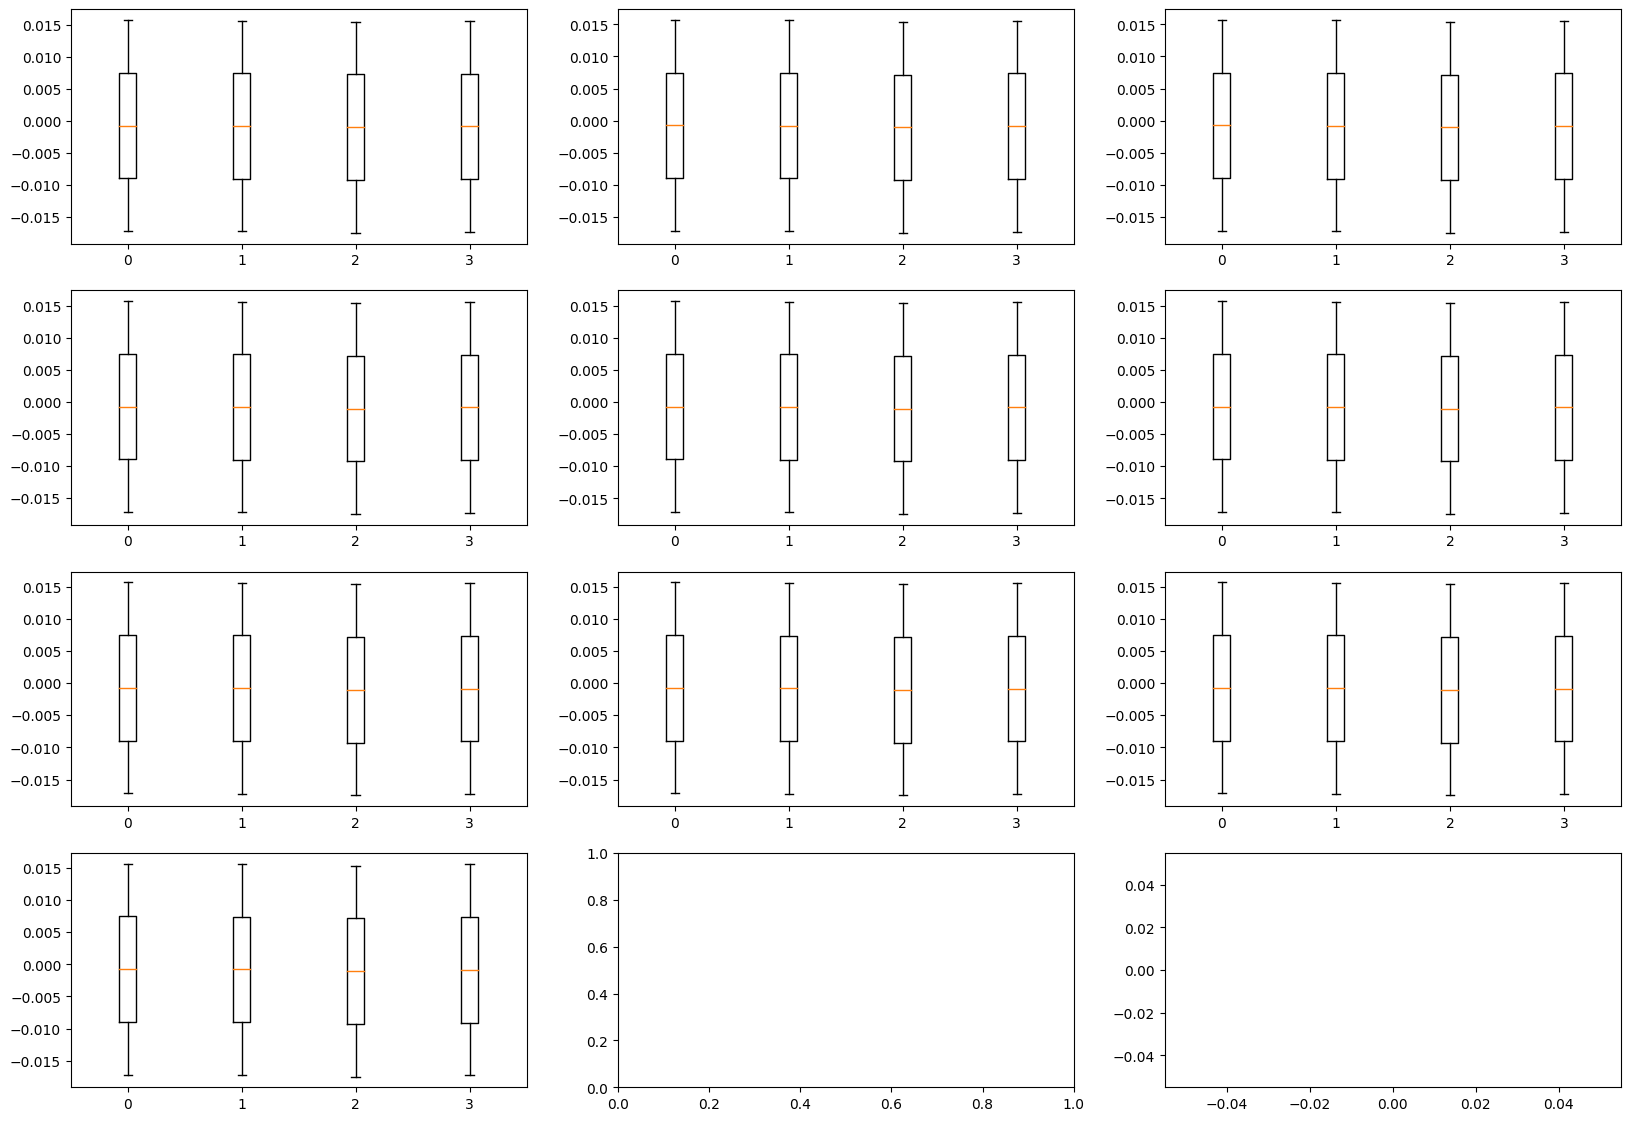

In [125]:
fig, axs = plt.subplots(4, 3, figsize=(20, 14))

for version_index in range(1, 5):
  version_index = version_index -1
  log_file = logs_files[version_index].replace("_params.json", "_validation.csv")
  validation_df = pd.read_csv(log_file, header=[0, 1], index_col=0)
  validation_df.columns = validation_df.columns.swaplevel(0, 1)

  quantile_df = validation_df["close"][["org_q1", "org_q2", "org_q3"]]
  for index in range(0, 10):
    x_index = index // 3
    y_index = index % 3
    axs[x_index, y_index].boxplot([quantile_df.iloc[index].values], positions=[version_index])
plt.plot()

### Row Data (More date range)

Above result caliculated with date from 2014 to 2022. This is a bit short to learn. We can get longer data from Ducascopy, HistData etc.

In [ ]:
import zipfile
import os
import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [22]:
import glob
import os
import pandas as pd

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_30MIN.zip"

if os.path.exists(file_path):
    df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
    file_path = f"{data_folder}/HistData_USDJPY_30MIN.csv"

    if os.path.exists(file_path):
        df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
        files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

        for file in files:
            min_df = read_histdata_file(file)
            rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
            rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
            rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
            rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
            rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
            rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
            rolled_df.dropna(inplace=True)
            df = pd.concat([df, rolled_df], axis=0)
        df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")
df

open     high      low    close  volume
time                                                           
2000-05-30 17:30:00  106.600  106.600  106.600  106.600       0
2000-05-30 18:00:00  106.650  106.660  106.640  106.660       0
2000-05-30 18:30:00  106.670  106.670  106.580  106.600       0
2000-05-30 19:00:00  106.620  106.640  106.620  106.620       0
2000-05-30 19:30:00  106.640  106.690  106.640  106.690       0
...                      ...      ...      ...      ...     ...
2022-12-30 14:30:00  130.952  131.020  130.925  130.971       0
2022-12-30 15:00:00  130.969  131.132  130.969  131.051       0
2022-12-30 15:30:00  131.050  131.291  130.996  131.269       0
2022-12-30 16:00:00  131.269  131.269  131.046  131.061       0
2022-12-30 16:30:00  131.059  131.172  131.059  131.106       0

[275522 rows x 5 columns]

In [23]:
ohlc_column = ['open','high','low','close']
freq=30
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq=freq, time_column= "index")
#ohlc_pre_process = [log_p, diff_p, time_p]
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [24]:
from Dataset.transformer import TimeFeatureDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_wt_transformer_ext"

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, index_sampler="k_fold", device=device)

#### Validation

In [21]:
model_name = "finance_basic_wt_transformer_ext"
model_version = 2
feature_size = 4

_, model = load_model(model_name, model_version, device, False, storage_handler=storage_handler)

File not found: 409, {"error_summary": "path/not_found/...", "error": {".tag": "path", "path": {".tag": "not_found"}}}
exsisting model params not found.


[]

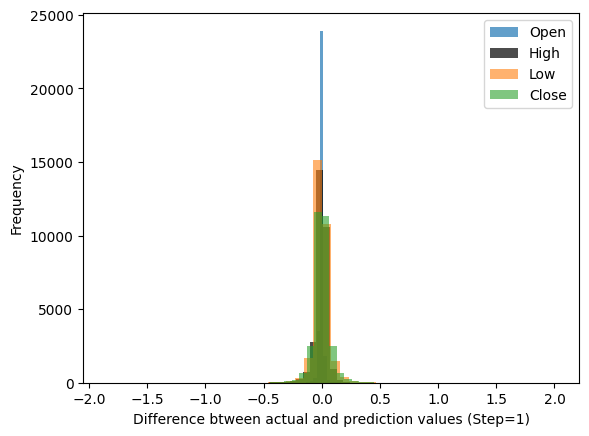

In [ ]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

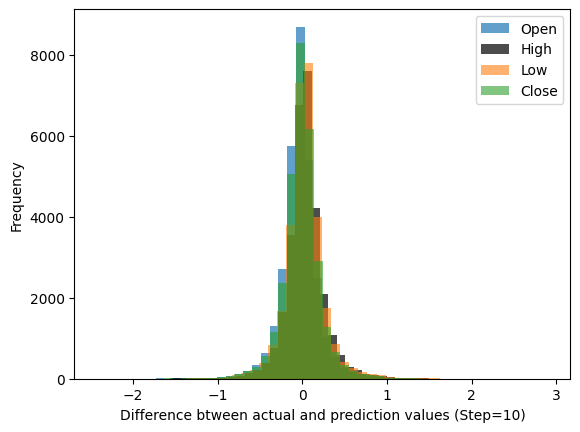

In [ ]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
diff_array = ohlc_pre[1:] - ohlc_ans[1:]
columns = ["open", "high", "low", "close"]
mean_df = pd.DataFrame(np.mean(diff_array, axis=1), columns=columns)
var_df = pd.DataFrame(np.var(diff_array, axis=1), columns=columns)

print(mean_df)
print(var_df)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for step in range(1, 11):

  axs[0,0].scatter(ohlc_ans_org[step, :, 0], ohlc_pre_org[step, :, 0], label=f'Tick {step}')
  axs[0,1].scatter(ohlc_ans_org[step, :, 1], ohlc_pre_org[step, :, 1], label=f'Tick {step}')
  axs[1,0].scatter(ohlc_ans_org[step, :, 2], ohlc_pre_org[step, :, 2], label=f'Tick {step}')
  axs[1,1].scatter(ohlc_ans_org[step, :, 3], ohlc_pre_org[step, :, 3], label=f'Tick {step}')
axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

In [ ]:
quant_1_df = pd.DataFrame(np.quantile(diff_array, 0.25, axis=1), columns=columns)
quant_2_df = pd.DataFrame(np.quantile(diff_array, 0.5, axis=1), columns=columns)
quant_3_df = pd.DataFrame(np.quantile(diff_array, 0.75, axis=1), columns=columns)
min_df = pd.DataFrame(np.min(diff_array, axis=1), columns=columns)
max_df = pd.DataFrame(np.max(diff_array, axis=1), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for index in range(0, 10):
  axs[0,0].boxplot(diff_array[index, :, 0], positions=[index+1])
  axs[0,1].boxplot(diff_array[index, :, 1], positions=[index+1])
  axs[1,0].boxplot(diff_array[index, :, 2], positions=[index+1])
  axs[1,1].boxplot(diff_array[index, :, 3], positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

In [ ]:
diff_array_org = ohlc_pre_org[1:] - ohlc_ans_org[1:]
mean_org_df = pd.DataFrame(np.mean(diff_array_org, axis=1), columns=["open", "high", "low", "close"])
var_org_df = pd.DataFrame(np.var(diff_array_org, axis=1), columns=["open", "high", "low", "close"])

print(mean_org_df)
print(var_org_df)

In [ ]:
validation_file_path = f'{data_folder}/{model_name}/{model_name}_v{model_version}_validation.csv'
validation_df = pd.concat([
    mean_df, var_df, quant_1_df, quant_2_df, quant_3_df, min_df, max_df,
    mean_org_df, var_org_df, quant_1_org_df, quant_2_org_df, quant_3_org_df, min_org_df, max_org_df,
    ],
    keys=[
        "mean", "var", "q1", "q2", "q3", "min", "max",
        "org_mean", "org_var", "org_q1", "org_q2", "org_q3", "org_min", "org_max"
        ],
    axis=1)
validation_df.to_csv(validation_file_path)
if storage_handler is not None:
    destination_file_path = f'/{model_name}/{model_name}_v{model_version}_validation.csv'
    storage_handler.upload_file(validation_file_path, destination_file_path)

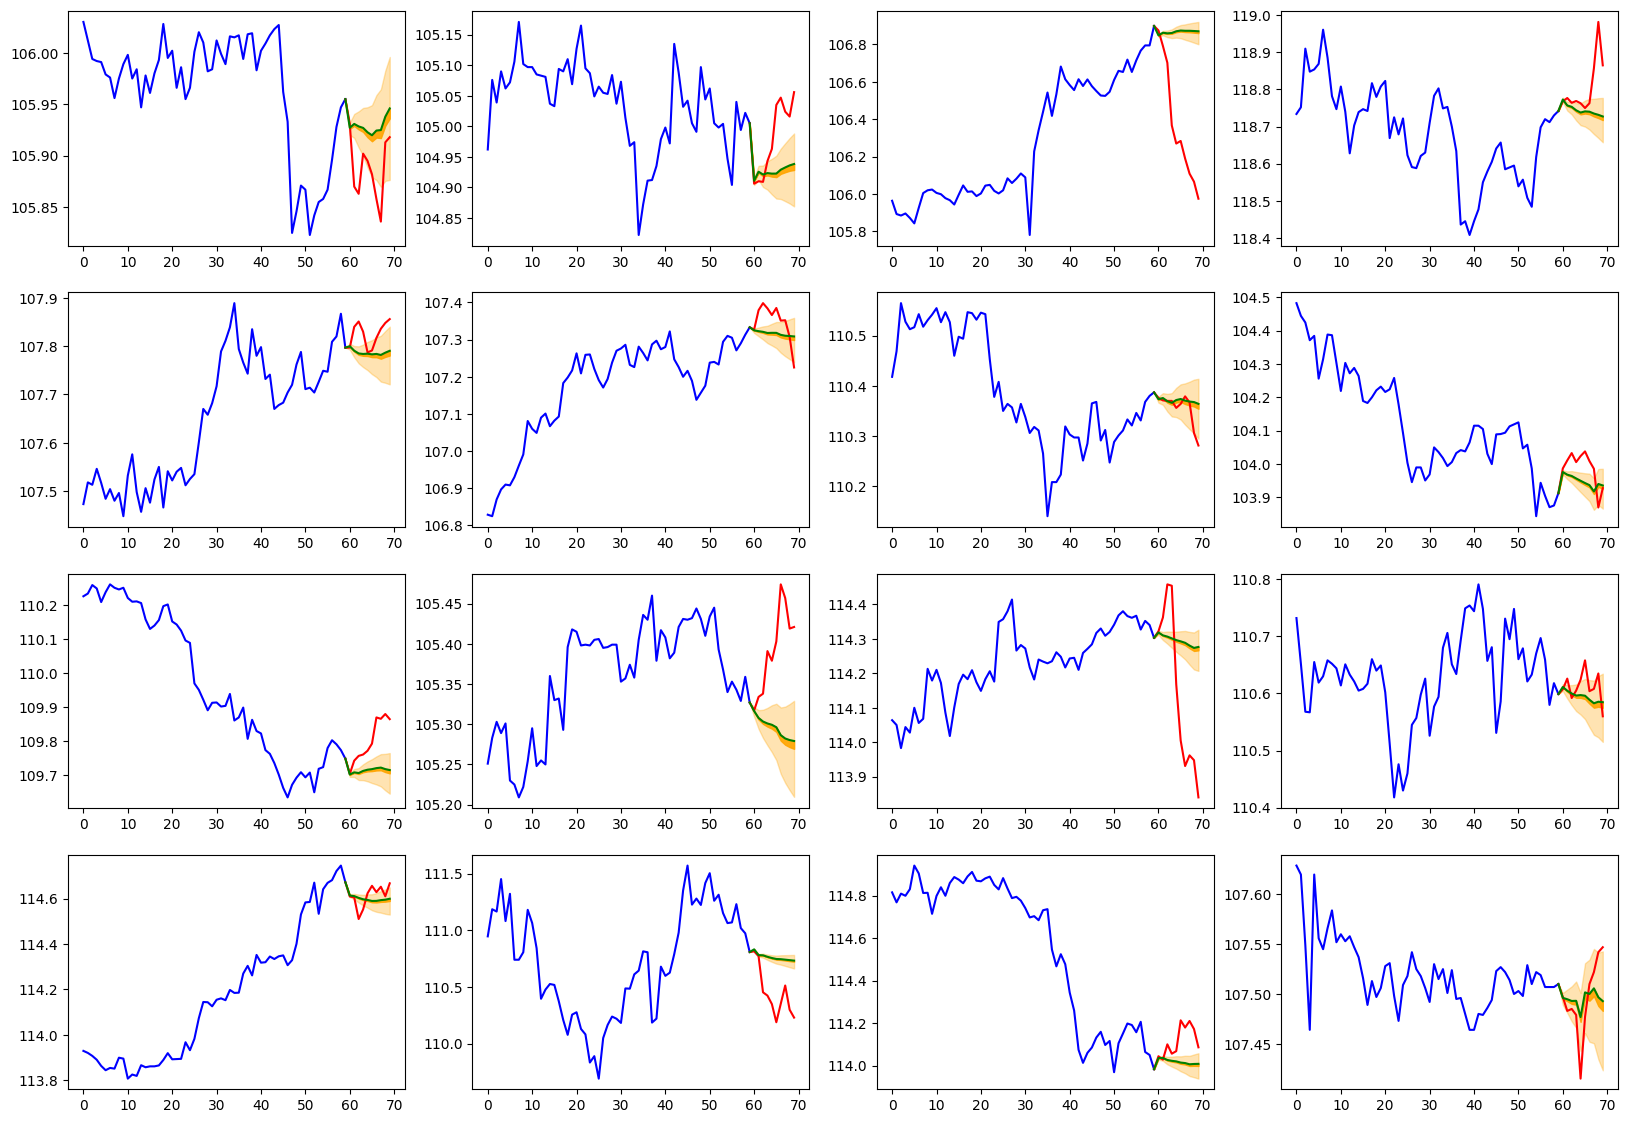

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[0]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 0]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 0], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

#### Summary

In [ ]:
model_name = "finance_basic_wt_transformer_ext"
model_versions = [1, 2, 3, 4]

for model_version in model_versions:
  destination_path = f"/{model_name}/{model_name}_v{model_version}.csv"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}.csv"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}.csv was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}.csv")

  destination_path = f"/{model_name}/{model_name}_v{model_version}_params.json"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}_params.json"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}_params.json was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}_params.json")

  destination_path = f"/{model_name}/{model_name}_v{model_version}_validation.csv"
  local_path = f"{data_folder}/{model_name}/{model_name}_v{model_version}_validation.csv"
  if os.path.exists(local_path):
    pass
  else:
    response = storage_handler.download_file(destination_path, local_path)
    if response is not None:
      print(f"{model_name}_v{model_version}_validation.csv was downloaded")
    else:
      print(f"failed to download {model_name}_v{model_version}_validation.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
logs_files = glob.glob(f"{data_folder}/{model_name}/{model_name}*_params.json")
logs_files.sort()

eval_loss = []
train_loss = []
eval_params = []

for index, log_file in enumerate(logs_files):
    color_index = index % len(colors)
    with open(log_file) as fp:
        params = json.load(fp)
    params_num = params["params_num"]
    log_file = log_file.replace("_params.json", ".csv")
    logs = pd.read_csv(log_file, header=None)
    logs = logs.iloc[1:]
    logs.columns = ["time","train_loss", "eval_loss"]
    eval_params.append(params_num)
    eval_loss.append(logs.eval_loss.min())
    train_loss.append(logs.train_loss.min())
    plt.yscale("log")
    plt.plot([*logs.index], logs.eval_loss, label=params_num, color=colors[color_index])
    plt.plot([*logs.index], logs.train_loss, label=f"{params_num}(train)", linestyle='--', color=colors[color_index])
plt.xlabel("epoc count")
plt.ylabel("eval loss")
plt.legend()
plt.show()

### Row Data with Filtering

In [ ]:
import os
import pandas as pd

model_name = "finance_basic_wt_transformer_filter"
ohlc_column = ['open','high','low','close']
file_name = "mt5_USDJPY_min30.csv"

file_path = os.path.join(data_folder, 'fx', 'OANDA-Japan MT5 Live', file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df

open     high      low    close  tick_volume  spread  \
time                                                                           
2014-07-07 08:30:00  102.086  102.122  102.081  102.102          738       3   
2014-07-07 09:00:00  102.102  102.146  102.098  102.113         1036       3   
2014-07-07 09:30:00  102.113  102.115  102.042  102.044          865       3   
2014-07-07 10:00:00  102.047  102.052  102.005  102.019          983       3   
2014-07-07 10:30:00  102.017  102.025  101.918  101.941         1328       3   
...                      ...      ...      ...      ...          ...     ...   
2022-08-12 21:30:00  133.461  133.506  133.439  133.484         1125       3   
2022-08-12 22:00:00  133.484  133.530  133.437  133.475         1277       3   
2022-08-12 22:30:00  133.475  133.486  133.433  133.483         1506       3   
2022-08-12 23:00:00  133.484  133.536  133.465  133.521         1038       3   
2022-08-12 23:30:00  133.521  133.522  133.301  133.313         2515       3   

                     real_volume  
time                              
2014-07-07 08:30:00            0  
2014-07-07 09:00:00            0  
2014-07-07 09:30:00            0  
2014-07-07 10:00:00            0  
2014-07-07 10:30:00            0  
...                          ...  
2022-08-12 21:30:00            0  
2022-08-12 22:00:00            0  
2022-08-12 22:30:00            0  
2022-08-12 23:00:00            0  
2022-08-12 23:30:00            0  

[100720 rows x 7 columns]

In [ ]:
target_columns = ["open","high", "low", "close"]

# create condition_df
def anomary_index(df, target_columns, alpha = 3):
    target_df = df[target_columns].diff()
    stats_df = target_df.describe()
    condition_df = pd.DataFrame()

    condition_df["upper"] = stats_df.loc["mean"] + stats_df.loc["std"] * alpha
    condition_df["lower"] = stats_df.loc["mean"] - stats_df.loc["std"] * alpha
    match_df = target_df[(target_df >= condition_df["upper"]) | (target_df <= condition_df["lower"])].dropna(how="all")
    return match_df.index

filter_index = anomary_index(df, target_columns, 3)
len(filter_index)

3954

#### Training

In [ ]:
target_columns = ["open","high", "low", "close"]

# create condition_df
def common_index(df, target_columns, observation_length, prediction_length, alpha = 3):
    target_df = df[target_columns].diff()
    stats_df = target_df.describe()
    condition_df = pd.DataFrame()

    condition_df["upper"] = stats_df.loc["mean"] + stats_df.loc["std"] * alpha
    condition_df["lower"] = stats_df.loc["mean"] - stats_df.loc["std"] * alpha
    match_df = target_df[(target_df < condition_df["upper"]) & (target_df > condition_df["lower"])]
    data_length = observation_length + prediction_length

    valid_indices = []
    for index in range(data_length, len(match_df)):
        train_data = match_df.iloc[index - data_length:index]
        if train_data.isnull().any().any():
            continue
        valid_indices.append(index)
    return valid_indices

train_data_index = common_index(df, target_columns, 60, 10, 3)

In [ ]:
diff_p = fprocess.DiffPreProcess(columns=target_columns)
time_p = fprocess.WeeklyIDProcess(freq=30, time_column= "index")
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=target_columns)
processes = [*ohlc_pre_process, standalization_p]

In [ ]:
from Dataset.transformer import TimeFeatureDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, target_columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, device=device, indices=train_data_index)

In [ ]:
# check outputs represent (data_length, chunk_size, feature_size)
ds.train()
for index in range(0, len(ds)-16, 16):
    src, tgt = ds[index: index+16]
    break
print(src[0].shape, src[1].shape)
print(tgt[0].shape, tgt[1].shape)

torch.Size([60, 16, 4]) torch.Size([60, 16])
torch.Size([11, 16, 4]) torch.Size([11, 16])


In [ ]:
feature_size = len(target_columns)
freq = 30

# Hyper parameters
nhead = 1
dim_feedforward = 10
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.1


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)



params = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params += p.numel()
print(f"params: {params}")

params: 2280


In [ ]:
lr = 0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.9)

In [ ]:
model_version = 1

log_file_name = f"{model_name}_v{model_version}.csv"
logger = Logger(model_name, model_version, data_folder, storage_handler=storage_handler)

params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": target_columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

logger.save_params(params, model_name, model_version)

print("training log will be saved on ", logger.log_file_path)

In [ ]:
epoch = 500
best_train_loss = float('Inf')
best_valid_loss = float('Inf')
best_model = None
best_train_model = None
patience = 3
counter = 0

for loop in range(1, epoch + 1):

    start_time = time.time()

    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )

    elapsed_time = time.time() - start_time

    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )

    elapsed_mins = math.floor(elapsed_time / 60)
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_valid_loss > loss_valid else ''
    ))
    logger.add_training_log(loss_train, loss_valid, elapsed_time)

    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
          logger.save_model(best_train_model, f'./{model_name}_train', model_version)
        scheduler.step()
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        logger.save_model(best_model, model_name, model_version)

    if counter > patience:
        break

#### Validation

In [ ]:
model_version = 1
print(f"loading {model_name}_v{model_version}")
model.load_state_dict(torch.load(f'{data_folder}/{model_name}/{model_name}_v{model_version}.torch'))

In [ ]:
def prediction(inputs, tgt_time_org):
    inputs, src_time = inputs
    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1, :, :]
    # instead of caliculate next tick time, use tgt_time provided by dataset
    tgt_time = tgt_time_org[:1, :]
    while preds.size(0) <= prediction_length:
        current_length = preds.size(0)
        tgt_time = tgt_time_org[:current_length, :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, src_time=src_time,
                    tgt=preds, tgt_time=tgt_time,
                    mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [ ]:
pred_sample = prediction(src, tgt[1])
pred_sample[:, 0, :]

In [ ]:
from Dataset import revert_process

src_values = src[0].cpu().detach().numpy()
r_data = revert_process.revert(ds, src_values, [index for index in range(0, 16)], is_tgt=False)
r_data[:, 0, :]

In [ ]:
from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 1000
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))

    preds = prediction(val_inp, val_ans[1])
    pre_values = preds.cpu().detach().numpy()

    ohlc = revert_process.revert(ds, pre_values, ndx, True, columns=ohlc_column)

    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)

    ans_values = val_ans[0].cpu().detach().numpy()

    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True, columns=ohlc_column)

    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

[]

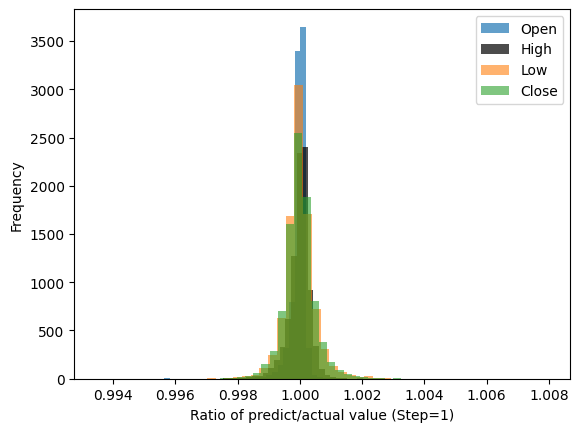

In [ ]:
import matplotlib.pyplot as plt

step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

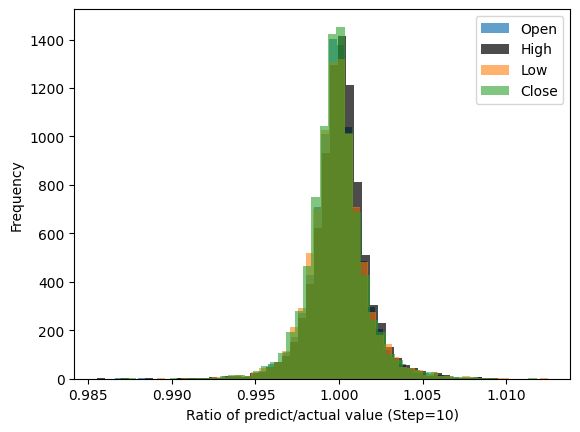

In [ ]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

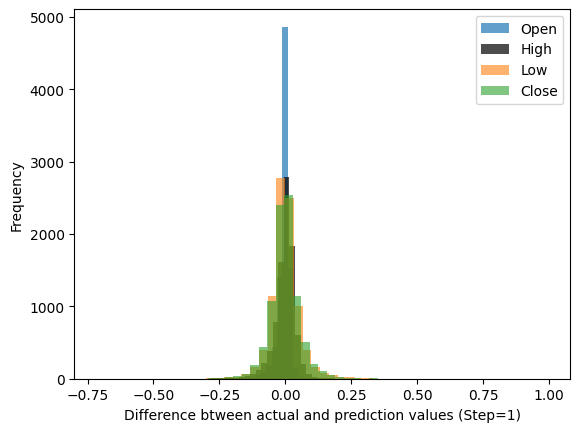

In [ ]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

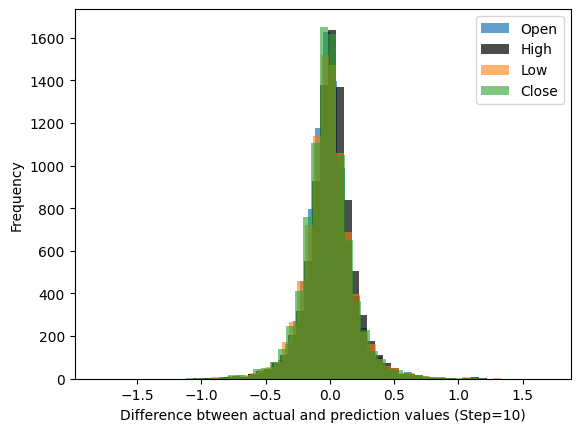

In [ ]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.0046  -0.00294 -0.00424 -0.00435 -0.00501 -0.00543 -0.00607
 -0.00656 -0.00693 -0.0072 ]
High [ 0.      -0.00262 -0.00033  0.00051  0.002    0.00323  0.0045   0.00572
  0.00704  0.00844  0.00998]
Low [ 0.      -0.00057 -0.0019  -0.00278 -0.00393 -0.00498 -0.00612 -0.00729
 -0.00833 -0.00947 -0.01048]
Close [ 0.      -0.0011  -0.00304 -0.00474 -0.00663 -0.00844 -0.01044 -0.01235
 -0.01417 -0.01595 -0.01768]
==============Var============
Open [0.      0.00093 0.00462 0.00799 0.01167 0.0154  0.01929 0.02336 0.02752
 0.03171 0.03604]
High [0.      0.00204 0.00581 0.00952 0.01325 0.01711 0.02125 0.02534 0.02949
 0.03376 0.03801]
Low [0.      0.00365 0.00769 0.01172 0.01559 0.01955 0.02357 0.02775 0.03204
 0.03632 0.04078]
Close [0.      0.00372 0.00742 0.01115 0.01491 0.01879 0.02285 0.02697 0.03118
 0.03546 0.03996]


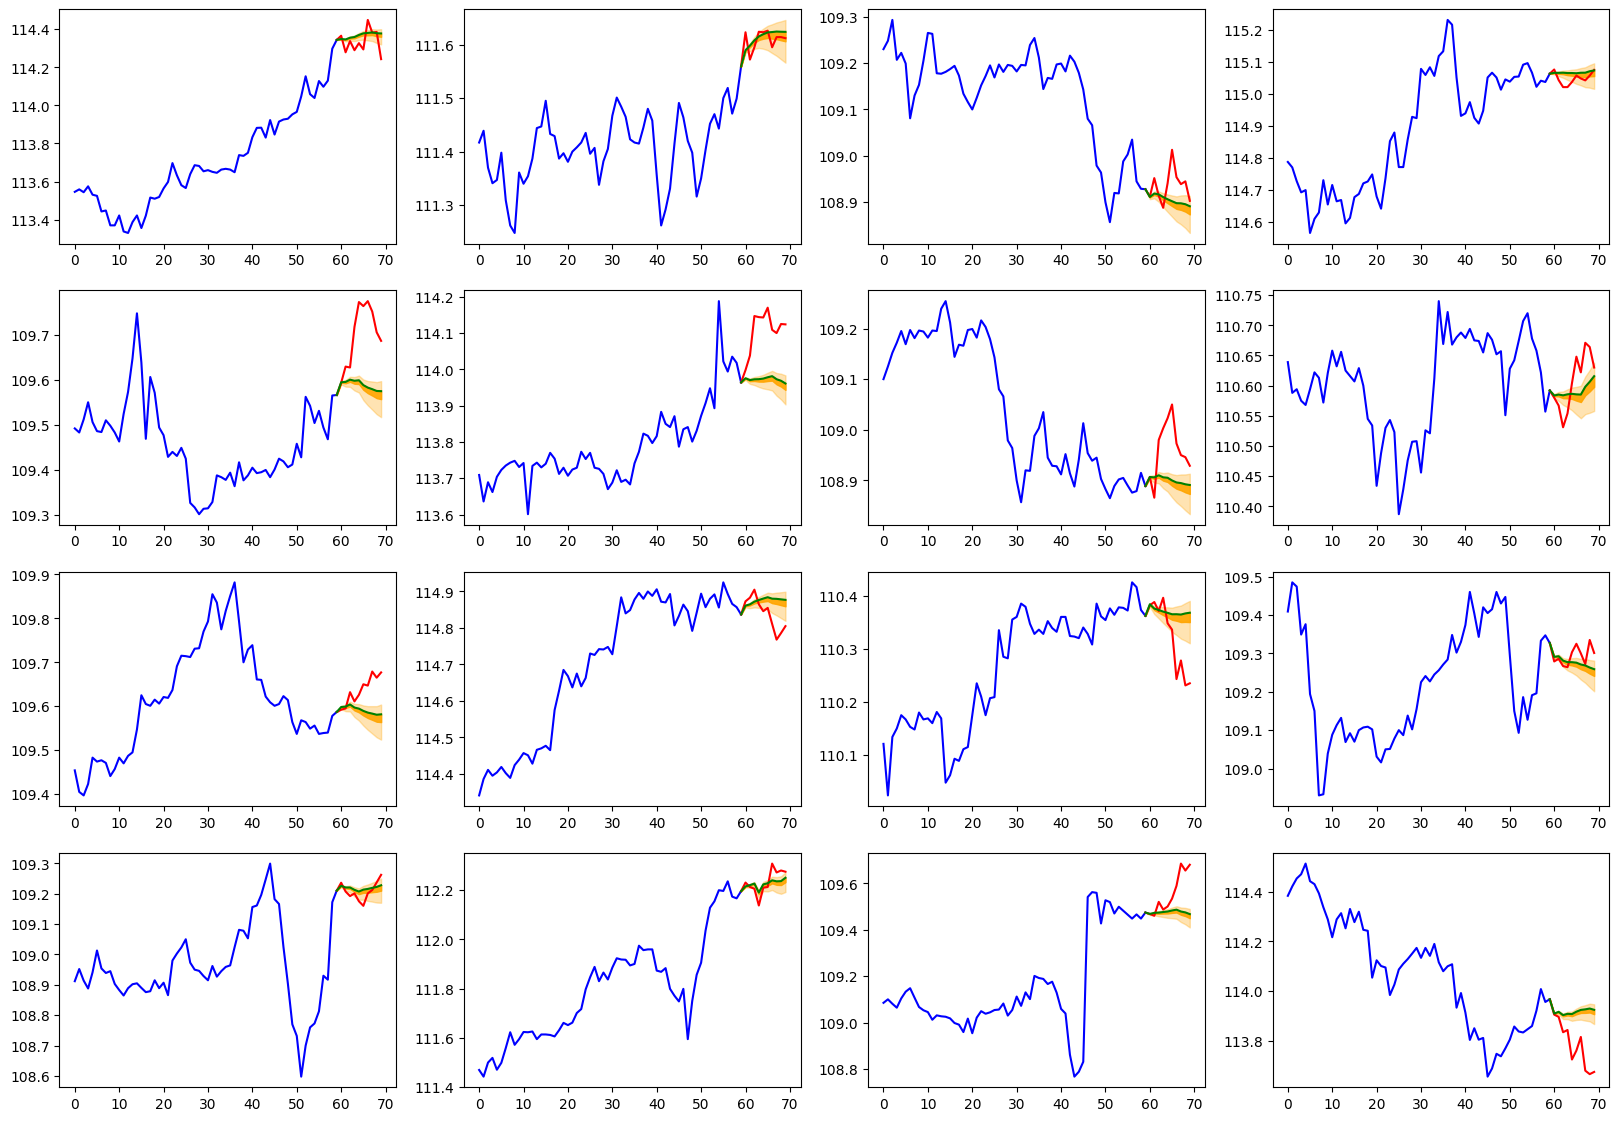

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)


for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[0]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 0]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length-1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length-1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 0], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

##### Compare with no filtering

Check whether the model predicts values more accurately than no filtering version or just filtered values are small

In [ ]:
model_name = "finance_basic_wt_transformer"
model_version = 1

model.load_state_dict(torch.load(f'{data_folder}/{model_name}/{model_name}_v{model_version}.torch'))

<All keys matched successfully>

In [ ]:
# validate no-filter model with filtered data

from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 1000
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))

    preds = prediction(val_inp, val_ans[1])
    pre_values = preds.cpu().detach().numpy()

    ohlc = revert_process.revert(ds, pre_values, ndx, True, columns=ohlc_column)

    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)

    ans_values = val_ans[0].cpu().detach().numpy()

    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True, columns=ohlc_column)

    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

[]

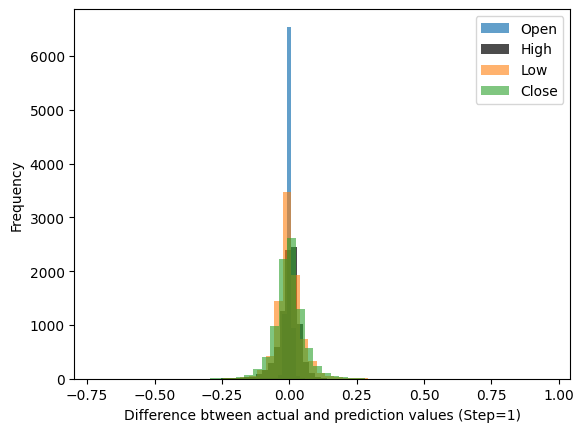

In [ ]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

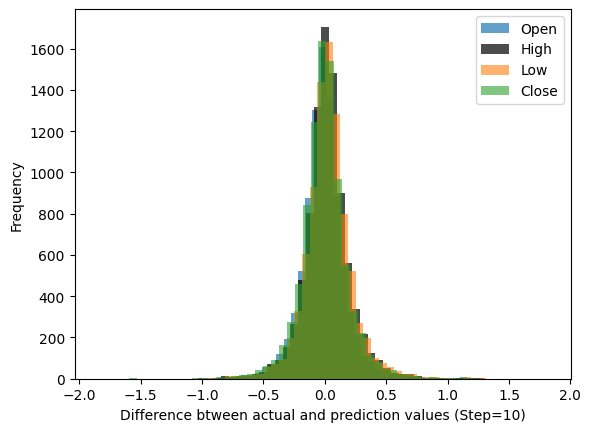

In [ ]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
# accuracy for filtered values are almost same for both models


np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00173 -0.0017  -0.00364 -0.00497 -0.0067  -0.00827 -0.0101
 -0.01186 -0.01355 -0.0152 ]
High [ 0.      -0.00176  0.00225  0.00368  0.00602  0.00797  0.00996  0.01185
  0.0138   0.01583  0.01795]
Low [0.      0.0003  0.00461 0.00779 0.01132 0.01473 0.0181  0.02142 0.02487
 0.02823 0.03171]
Close [ 0.      -0.00047 -0.00079 -0.00124 -0.0017  -0.00214 -0.00275 -0.00328
 -0.00371 -0.0041  -0.00442]
==============Var============
Open [0.      0.00015 0.00379 0.00759 0.01138 0.01517 0.0191  0.02324 0.02738
 0.03165 0.03593]
High [0.      0.00197 0.00567 0.00944 0.01316 0.01702 0.02119 0.02531 0.02954
 0.03393 0.0383 ]
Low [0.      0.00297 0.00708 0.0111  0.01504 0.01906 0.02318 0.02736 0.03172
 0.03596 0.04036]
Close [0.      0.00369 0.00739 0.0111  0.01484 0.01872 0.02277 0.02688 0.03108
 0.03533 0.03984]


As it is almost the same mean/var with filter case, there is no impact for accuracy.

### Summary

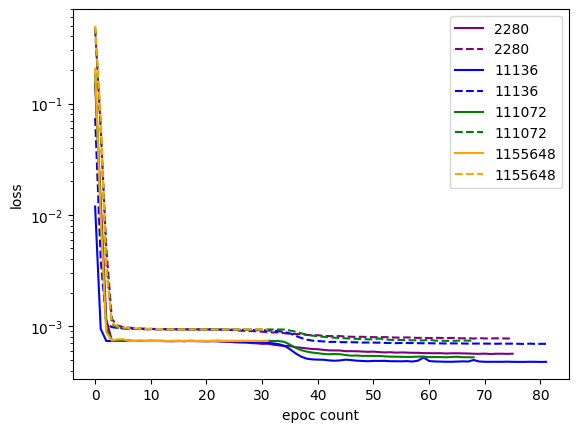

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob

model_name = "finance_basic_wt_transformer_filter"
logs_files = glob.glob(f"{data_folder}/{model_name}/{model_name}*_params.json")
colors = ['Purple', 'Blue', 'Green', 'Orange', 'Red',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn', 'Grey']

eval_loss_row = []
eval_params_row = []

for index, log_file in enumerate(logs_files):
    with open(log_file) as fp:
        params = json.load(fp)
    params_num = params["params_num"]
    log_file = log_file.replace("_params.json", ".csv")
    logs = pd.read_csv(log_file, header=None)
    logs.columns = ["time", "train_loss", "eval_loss"]
    eval_params_row.append(params_num)
    eval_loss_row.append(logs.eval_loss.min())
    plt.yscale("log")
    plt.plot([*logs.index], logs.eval_loss, label=params_num, color=colors[index])
    plt.plot([*logs.index], logs.train_loss, label=params_num, linestyle="--", color=colors[index])
plt.xlabel("epoc count")
plt.ylabel("loss")
plt.legend()
plt.show()

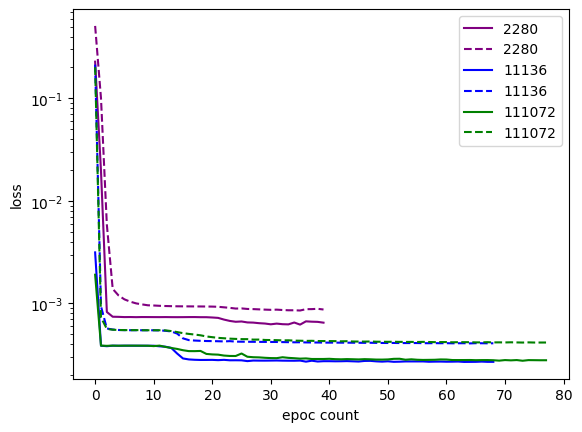

In [ ]:
model_name = "finance_basic_wt_transformer_filter_ext"
logs_files = glob.glob(f"{data_folder}/{model_name}/{model_name}*_params.json")

eval_loss_ext = []
eval_params_ext = []

for index, log_file in enumerate(logs_files):
    with open(log_file) as fp:
        params = json.load(fp)
    params_num = params["params_num"]
    log_file = log_file.replace("_params.json", ".csv")
    logs = pd.read_csv(log_file, header=None)
    logs.columns = ["time", "train_loss", "eval_loss"]
    eval_params_ext.append(params_num)
    eval_loss_ext.append(logs.eval_loss.min())
    plt.yscale("log")
    plt.plot([*logs.index], logs.eval_loss, label=params_num, color=colors[index])
    plt.plot([*logs.index], logs.train_loss, label=params_num, linestyle="--", color=colors[index])
plt.xlabel("epoc count")
plt.ylabel("loss")
plt.legend()
plt.show()

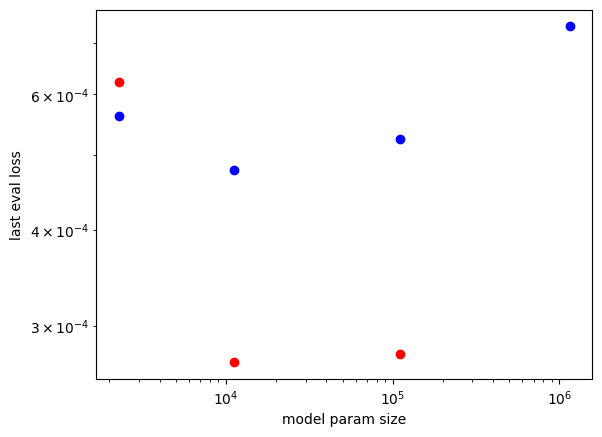

In [ ]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("model param size")
plt.ylabel("last eval loss")
plt.plot(eval_params_row, eval_loss_row, 'o', color='blue')
plt.plot(eval_params_ext, eval_loss_ext, 'o', color='red')
plt.show()

### Argumented Data with Shift Rolling

We have 2 possible reason that expect why validation loss stopped improvement

1. data volume is less
2. data feature is less

I suspect data feature is less. To confirm that, increase the data volume by rolling 1min data to 30min data with shifting the time.

2 will be confirmed by appling linear or conv1d layer to input (ref another notebook)

In [ ]:
import zipfile
import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_format='%Y%m%d %H%M%S', index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [ ]:
import glob
import os

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"

folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

for file in files:
    min_df = read_histdata_file(file)
    df = pd.concat([df, min_df], axis=0)

In [ ]:
freq = 30
freq_str = "30MIN"

org_df = df.groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()

DFS = []
BIAS = 2

for bias in range(-BIAS, BIAS+1):
    min_df = df.copy()
    min_df.index += pd.Timedelta(minutes=bias)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq=freq_str)).max().dropna()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq=freq_str)).min().dropna()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq=freq_str)).last().dropna()
    #rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq=freq_str)).sum()
    #rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close], axis=1)
    rolled_df = rolled_df[rolled_df.index.isin(org_df.index)]
    DFS.append(rolled_df)

In [ ]:
from Dataset.transformer import TimeFeatureDataset

ds_array = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for df_ in DFS:
  ohlc_column = ['open','high','low','close']
  #volume_column = ["tick_volume"]
  #columns = ohlc_column+volume_column
  columns = ohlc_column

  #log_p = fprocess.LogPreProcess(columns=ohlc_column)
  diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
  time_p = fprocess.WeeklyIDProcess(freq=freq, time_column= "index")
  #ohlc_pre_process = [log_p, diff_p, time_p]
  ohlc_pre_process = [diff_p, time_p]

  standalization_p = fprocess.MinMaxPreProcess(columns=columns)
  processes = [*ohlc_pre_process, standalization_p]

  #Dataset parameters
  batch_size = 64
  observation_length = 60
  prediction_length = 10

  ds = TimeFeatureDataset(df_, columns, time_column="index",
                          processes=processes, observation_length=observation_length,
                          prediction_length=prediction_length, device=device)
  ds_array.append(ds)

#### Training

In [ ]:
def train(model, ds_array, optimizer, criterion, batch_size, device):

    model.train()
    losses = 0
    length = 0
    end_index = 0

    mini_batch = int(batch_size/len(ds_array))
    if mini_batch <= 1:
        mini_batch = 2

    ds_length = []
    for ds in ds_array:
        ds.train()
        ds_length.append(len(ds))

    end_index = min(ds_length)

    end = False
    for index in tqdm(range(0, end_index - mini_batch, mini_batch)):
        length+=1.0
        sources = []
        sources_time = []
        targets = []
        targets_time = []
        for ds in ds_array:
            try:
                src, tgt = ds[index:index+mini_batch]
                sources.append(src[0])
                sources_time.append(src[1])
                targets.append(tgt[0])
                targets_time.append(tgt[1])
            except:
                end = True
                break
        if end:
            break
        src = torch.concat(sources, dim=1)
        src_time = torch.concat(sources_time, dim=1)
        tgt = torch.concat(targets, dim=1)
        tgt_time = torch.concat(targets_time, dim=1)

        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size, device):

    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()

    return losses / length

In [ ]:
feature_size = 4
freq=30

# Hyper parameters
nhead = 1
dim_feedforward = 10
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.01


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)


params = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params += p.numel()

In [ ]:
lr = 0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

model_name = f"finance_basic_wt_transformer_shift{BIAS}"
model_version = "1"

log_file_path = "{model_name}_{model_version}.csv"
logger = Logger(model_name, model_version, data_folder, storage_handler=storage_handler)

params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

logger.save_params(params, model_name, model_version)
print("training log will be saved on ", logger.log_file_path)

In [ ]:
epoch = 500
best_train_loss = float('Inf')
best_valid_loss = float('Inf')
best_model = None
best_train_model = None
patience = 3
counter = 0

ACTUAL_DS_INDEX = BIAS

for loop in range(1, epoch + 1):

    start_time = time.time()

    loss_train = train(
        model=model, ds_array=ds_array, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )

    elapsed_time = time.time() - start_time

    loss_valid = evaluate(
        model=model, ds=ds_array[ACTUAL_DS_INDEX], criterion=criterion,
        batch_size=batch_size, device=device
    )

    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_valid_loss > loss_valid else ''
    )
    print(log)
    logger.add_training_log(loss_train, loss_valid)

    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
          logger.save_model(best_train_model, f'./{model_name}_train', model_version)
        scheduler.step()
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        logger.save_model(best_model, model_name, model_version)

    if counter > patience:
        break

100%|██████████| 4585/4585 [58:44<00:00,  1.30it/s] 


[1/500] train loss: 0.0006397066, valid loss: 0.0004781739  47s] count: 0, **


100%|██████████| 4585/4585 [1:00:59<00:00,  1.25it/s]


[2/500] train loss: 0.0006374280, valid loss: 0.0004722674  1s] count: 0, **


100%|██████████| 4585/4585 [59:01<00:00,  1.29it/s] 


[3/500] train loss: 0.0006343471, valid loss: 0.0004694718  3s] count: 0, **


100%|██████████| 4585/4585 [1:00:20<00:00,  1.27it/s]


[4/500] train loss: 0.0006264661, valid loss: 0.0004686276  22s] count: 0, **


100%|██████████| 4585/4585 [1:00:06<00:00,  1.27it/s]


[5/500] train loss: 0.0006245103, valid loss: 0.0004719404  8s] count: 0, 


100%|██████████| 4585/4585 [59:56<00:00,  1.27it/s] 


[6/500] train loss: 0.0006201566, valid loss: 0.0004711307  58s] count: 0, 


100%|██████████| 4585/4585 [1:00:06<00:00,  1.27it/s]


[7/500] train loss: 0.0006220293, valid loss: 0.0004637009  8s] count: 0, **


100%|██████████| 4585/4585 [1:00:43<00:00,  1.26it/s]


[8/500] train loss: 0.0006130252, valid loss: 0.0004657453  44s] count: 1, 


 17%|█▋        | 760/4585 [11:41<58:52,  1.08it/s]  


[9/500] train loss: 0.0006056204, valid loss: 0.0004704219  43s] count: 0, 


100%|██████████| 4585/4585 [1:05:47<00:00,  1.16it/s]


[10/500] train loss: 0.0006107292, valid loss: 0.0004653349  49s] count: 0, 


100%|██████████| 4585/4585 [59:53<00:00,  1.28it/s]  


[11/500] train loss: 0.0006134011, valid loss: 0.0004618430  55s] count: 1, **


100%|██████████| 4585/4585 [57:53<00:00,  1.32it/s] 


[12/500] train loss: 0.0006080195, valid loss: 0.0004650265  55s] count: 2, 


100%|██████████| 4585/4585 [55:45<00:00,  1.37it/s]


[13/500] train loss: 0.0006084723, valid loss: 0.0004658834  46s] count: 3, 


#### Validation

As validation loss is too high, skip the confirmation for now

### Argumented Data with Using Another Symbols

Note implemented yet.
Convert each symbol data to indicate almost same features. For example, applying diff then divide by minimum point of each symbol.

In [ ]:
import glob
import os

folder_path = os.path.abspath('L:/data/fx/Dukascopy')
# folders = glob.glob(folder_path + '/*JPY')
folders = [folder_path + '/USDJPY', folder_path + '/AUDJPY', folder_path + '/CHFJPY', folder_path + '/EURJPY']

In [ ]:
import pandas as pd
from tqdm import tqdm

df = pd.DataFrame()
ohlc_column = ['Open', 'High', 'Low', 'Close']
volume_column = "Volume"
DFS = []

for folder in folders:
    files = glob.glob(folder + '/*.csv')
    for file in tqdm(files):
        min_df = pd.read_csv(file, index_col=0, parse_dates=True)
        rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
        rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
        rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
        rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
        rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
        rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
        rolled_df.dropna(inplace=True)
        df = pd.concat([df, rolled_df], axis=0)
        DFS.append(df)

### Argumented Data with Applying All Ideas

Not implemented yet

### Add Features: volume and spread

In [ ]:
import os
import pandas as pd


ohlc_column = ['open','high','low','close']
additional_columns = ["tick_volume", "spread"]
file_path = os.path.abspath('../../Data/mt5_USDJPY_min30.csv')
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

#### Define Model
Same as Baseline with weekly position

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return position

In [ ]:
class Seq2SeqTransformer(nn.Module):

    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int, time_size:int =  24*7*2,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):

        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(time_size=time_size, d_model=feature_size)

        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self,
        src: Tensor, src_time: Tensor,
        tgt: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):

        src_time = self.positional_encoding(src_time)
        src = torch.add(src, src_time)
        tgt_time = self.positional_encoding(tgt_time)
        tgt = torch.add(tgt, tgt_time)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

In [ ]:
def train(model, ds, optimizer, criterion, batch_size, device):

    model.train()
    ds.train()
    losses = 0

    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size, device):

    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()

    return losses / length

#### Training

In [ ]:
columns = ohlc_column+additional_columns

#log_p = fprocess.LogPreProcess(columns=columns)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Dataset parameters
batch_size = 64
observation_length = 30
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length)

In [ ]:
# # check outputs represent (data_length, chunk_size, feature_size)
# ds.train()
# for index in range(0, len(ds)-16, 16):
#     src, tgt = ds[index: index+16]
#     break
# print(src[0].shape, src[1].shape)
# print(tgt[0].shape, tgt[1].shape)

In [ ]:
feature_size = 6
freq=30

# Hyper parameters
nhead = 2
dim_feedforward = 5000
num_encoder_layers = 12
num_decoder_layers = 12
dropout = 0.001


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [ ]:
lr = 0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

model_name = f"finance_basic_wt_transformer_nodiff_d0001"
model_version = "1"

log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print("number of parameters: ", params)

params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

In [ ]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 3
counter = 0

for loop in range(1, epoch + 1):

    start_time = time.time()

    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )

    elapsed_time = time.time() - start_time

    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )

    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    )
    logging.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    print(log)
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()

    if counter > patience:
        break

100%|█████████▉| 1101/1102 [11:33<00:00,  1.59it/s]


[1/500] train loss: 0.0578787685, valid loss: 0.0037063293  34s] count: 0, **


100%|█████████▉| 1101/1102 [09:49<00:00,  1.87it/s]


[2/500] train loss: 0.0021434757, valid loss: 0.0033608952  50s] count: 0, **


100%|█████████▉| 1101/1102 [09:44<00:00,  1.88it/s]


[3/500] train loss: 0.0020198564, valid loss: 0.0035293275  45s] count: 0, 


100%|█████████▉| 1101/1102 [09:45<00:00,  1.88it/s]


[4/500] train loss: 0.0019943540, valid loss: 0.0034053557  45s] count: 1, 


100%|█████████▉| 1101/1102 [09:48<00:00,  1.87it/s]


[5/500] train loss: 0.0020010936, valid loss: 0.0034459734  48s] count: 2, 


100%|█████████▉| 1101/1102 [09:44<00:00,  1.88it/s]


[6/500] train loss: 0.0019794028, valid loss: 0.0032379963  45s] count: 3, **


100%|█████████▉| 1101/1102 [09:41<00:00,  1.89it/s]


[7/500] train loss: 0.0019621129, valid loss: 0.0033722063  41s] count: 0, 


100%|█████████▉| 1101/1102 [09:50<00:00,  1.87it/s]


[8/500] train loss: 0.0019592808, valid loss: 0.0034250473  50s] count: 1, 


100%|█████████▉| 1101/1102 [09:43<00:00,  1.89it/s]


[9/500] train loss: 0.0019450955, valid loss: 0.0033467188  43s] count: 2, 


100%|█████████▉| 1101/1102 [09:44<00:00,  1.88it/s]


[10/500] train loss: 0.0019434208, valid loss: 0.0034109939  44s] count: 3, 


### Add Features: Another Symbols

Not implemented yet

In [ ]:
folder_path = os.path.abspath('L:/data/fx/HistData')

In [ ]:
import zipfile
import os

import pandas as pd

ohlc_columns = ['open', 'high', 'low', 'close', 'volume']

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ohlc_columns
    df.index.name = "time"
    return df

In [ ]:
import glob
import os

import pandas as pd
from tqdm import tqdm


folder_path = os.path.abspath('L:/data/fx/HistData')
symbols = ['USDJPY', 'EURJPY', 'AUDJPY', 'GBPJPY', 'CHFJPY', 'EURUSD', 'AUDUSD', 'GBPUSD', 'USDCHF']

In [ ]:

DFS = {}

for symbol in symbols:
    folder_path = os.path.abspath(f'L:/data/fx/HistData/{symbol}')
    files = glob.glob(folder_path + f'/DAT_ASCII_{symbol}_M1_*.zip')
    df = pd.DataFrame()

    for file in files:
        min_df = read_histdata_file(file)
        df = pd.concat([df, min_df], axis=0)
    DFS[symbol] = df

In [ ]:
for key ,df in DFS.items():
    df.to_csv(f'L:/data/fx/HistData_{key}_1MIN.csv')

In [ ]:
min_df = pd.read_csv(f'L:/data/fx/HistData_USDJPY_1MIN.csv', index_col=0, parse_dates=True)
min_df

open     high      low    close  volume
time                                                           
2000-05-30 17:58:00  106.600  106.600  106.600  106.600       0
2000-05-30 18:03:00  106.650  106.650  106.650  106.650       0
2000-05-30 18:19:00  106.640  106.650  106.640  106.650       0
2000-05-30 18:28:00  106.660  106.660  106.660  106.660       0
2000-05-30 18:33:00  106.670  106.670  106.670  106.670       0
...                      ...      ...      ...      ...     ...
2022-12-30 16:54:00  131.111  131.123  131.091  131.112       0
2022-12-30 16:55:00  131.109  131.119  131.090  131.101       0
2022-12-30 16:56:00  131.109  131.110  131.069  131.090       0
2022-12-30 16:57:00  131.090  131.103  131.081  131.090       0
2022-12-30 16:58:00  131.097  131.122  131.089  131.106       0

[7616436 rows x 5 columns]

In [ ]:
DFS = {}

for symbol in symbols:
    min_df = pd.read_csv(f'L:/data/fx/HistData_{symbol}_1MIN.csv', index_col=0, parse_dates=True)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
    rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    DFS[symbol] = rolled_df
df = pd.concat(DFS.values(), keys=DFS.keys() , axis=1)
df.dropna(inplace=True)
df

In [ ]:
df.to_csv(f'L:/data/fx/HistData_{len(symbols)}symbols_30MIN.csv')

In [ ]:
df = pd.read_csv(f'L:/data/fx/HistData_{len(symbols)}symbols_30MIN.csv', index_col=0, parse_dates=True, header=[0, 1])
df

USDJPY                                     EURJPY  \
                        open     high      low    close volume     open   
time                                                                      
2002-08-19 17:30:00  118.700  118.700  118.610  118.610    0.0  115.840   
2002-08-19 18:00:00  118.620  118.650  118.570  118.600    0.0  115.920   
2002-08-19 18:30:00  118.590  118.610  118.500  118.500    0.0  115.880   
2002-08-19 19:00:00  118.510  118.540  118.460  118.510    0.0  115.830   
2002-08-19 19:30:00  118.520  118.590  118.500  118.510    0.0  115.780   
...                      ...      ...      ...      ...    ...      ...   
2022-12-30 14:30:00  130.952  131.020  130.925  130.971    0.0  140.127   
2022-12-30 15:00:00  130.969  131.132  130.969  131.051    0.0  140.156   
2022-12-30 15:30:00  131.050  131.291  130.996  131.269    0.0  140.280   
2022-12-30 16:00:00  131.269  131.269  131.046  131.061    0.0  140.545   
2022-12-30 16:30:00  131.059  131.172  131.059  131.106    0.0  140.308   

                                                       ...   GBPUSD           \
                        high      low    close volume  ...     open     high   
time                                                   ...                     
2002-08-19 17:30:00  115.950  115.810  115.920    0.0  ...  1.52720  1.52740   
2002-08-19 18:00:00  116.000  115.840  115.870    0.0  ...  1.52740  1.52770   
2002-08-19 18:30:00  115.880  115.810  115.820    0.0  ...  1.52730  1.52760   
2002-08-19 19:00:00  115.860  115.750  115.770    0.0  ...  1.52770  1.52770   
2002-08-19 19:30:00  115.840  115.760  115.820    0.0  ...  1.52750  1.52770   
...                      ...      ...      ...    ...  ...      ...      ...   
2022-12-30 14:30:00  140.293  140.126  140.156    0.0  ...  1.20755  1.20804   
2022-12-30 15:00:00  140.317  140.136  140.278    0.0  ...  1.20631  1.20752   
2022-12-30 15:30:00  140.551  140.252  140.547    0.0  ...  1.20741  1.20892   
2022-12-30 16:00:00  140.555  140.287  140.308    0.0  ...  1.20884  1.20982   
2022-12-30 16:30:00  140.410  140.260  140.382    0.0  ...  1.20975  1.20991   

                                               USDCHF                    \
                         low    close volume     open     high      low   
time                                                                      
2002-08-19 17:30:00  1.52690  1.52740    0.0  1.50400  1.50430  1.50230   
2002-08-19 18:00:00  1.52710  1.52720    0.0  1.50240  1.50260  1.50150   
2002-08-19 18:30:00  1.52720  1.52760    0.0  1.50250  1.50290  1.50170   
2002-08-19 19:00:00  1.52700  1.52740    0.0  1.50180  1.50280  1.50160   
2002-08-19 19:30:00  1.52660  1.52700    0.0  1.50280  1.50350  1.50210   
...                      ...      ...    ...      ...      ...      ...   
2022-12-30 14:30:00  1.20621  1.20633    0.0  0.92350  0.92446  0.92303   
2022-12-30 15:00:00  1.20624  1.20742    0.0  0.92430  0.92533  0.92370   
2022-12-30 15:30:00  1.20732  1.20884    0.0  0.92399  0.92479  0.92347   
2022-12-30 16:00:00  1.20834  1.20976    0.0  0.92452  0.92482  0.92395   
2022-12-30 16:30:00  1.20891  1.20963    0.0  0.92451  0.92485  0.92425   

                                     
                       close volume  
time                                 
2002-08-19 17:30:00  1.50240      0  
2002-08-19 18:00:00  1.50250      0  
2002-08-19 18:30:00  1.50190      0  
2002-08-19 19:00:00  1.50260      0  
2002-08-19 19:30:00  1.50210      0  
...                      ...    ...  
2022-12-30 14:30:00  0.92428      0  
2022-12-30 15:00:00  0.92400      0  
2022-12-30 15:30:00  0.92454      0  
2022-12-30 16:00:00  0.92451      0  
2022-12-30 16:30:00  0.92442      0  

[238498 rows x 45 columns]

In [ ]:
diff_p = fprocess.DiffPreProcess(columns=['open', 'high', 'low', 'close'])
time_p = fprocess.WeeklyIDProcess(freq=30, time_column= "index")
std_p = fprocess.MinMaxPreProcess(columns=['open', 'high', 'low', 'close'], grouped_by_symbols=False)

In [ ]:
df.columns = df.columns.swaplevel(0, 1)

In [ ]:
from Dataset.transformer import TimeFeatureDataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ohlc_columns = ['open', 'high', 'low', 'close']
processes = [time_p, diff_p, std_p]

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, ohlc_columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, device=device)

In [ ]:
src, tgt = ds[0:10]

In [ ]:
src, src_positions = src

In [ ]:
src_positions[:, 0]

tensor([[183],
        [184],
        [185],
        [186],
        [187],
        [188],
        [189],
        [190],
        [191],
        [  0],
        [  1],
        [  2],
        [  3],
        [  4],
        [  5],
        [  6],
        [  7],
        [  8],
        [  9],
        [ 10],
        [ 11],
        [ 12],
        [ 13],
        [ 14],
        [ 15],
        [ 16],
        [ 17],
        [ 18],
        [ 19],
        [ 20],
        [ 21],
        [ 22],
        [ 23],
        [ 24],
        [ 25],
        [ 26],
        [ 27],
        [ 28],
        [ 29],
        [ 30],
        [ 31],
        [ 32],
        [ 33],
        [ 34],
        [ 35],
        [ 36],
        [ 37],
        [ 38],
        [ 39],
        [ 40],
        [ 41],
        [ 42],
        [ 43],
        [ 44],
        [ 45],
        [ 46],
        [ 47],
        [ 24],
        [ 25],
        [ 26]], device='cuda:0', dtype=torch.int32)

In [ ]:
time_index = df.index

In [ ]:
(time_index.hour + time_index.minute / 60 ) * 2

Float64Index([35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0,
              ...
              24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0],
             dtype='float64', name='time', length=238498)

In [ ]:
time_index.hour

Int64Index([17, 18, 18, 19, 19, 20, 20, 21, 21, 22,
            ...
            12, 12, 13, 13, 14, 14, 15, 15, 16, 16],
           dtype='int64', name='time', length=238498)

In [ ]:
(time_index.weekday * 24 + time_index.hour + time_index.minute / 60 * 2).to_frame().convert_dtypes(int)

time
time       
18.0     18
18.0     18
19.0     19
19.0     19
20.0     20
...     ...
111.0   111
111.0   111
112.0   112
112.0   112
113.0   113

[238498 rows x 1 columns]

# BaseLine Transformer model with Position Learning

When data is argumented with time shift, position index based on datetime is not proper. Change the weekly time position to just index of array.

In [ ]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
# for Colab
import sys, os

module_path = os.path.abspath("/content/drive/My Drive/modules")
sys.path.append(module_path)

from Dataset.transformer import TimeFeatureDataset
import fprocess

In [ ]:
import sys, os

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.transformer import TimeFeatureDataset
from fprocess import fprocess

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self, pos_ids):
        position = self.pe(pos_ids)
        return position

In [ ]:
class Seq2SeqTransformer(nn.Module):

    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int, time_size:int =  24*7*2,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):

        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(time_size=time_size, d_model=feature_size)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self,
        src: Tensor, src_pos: Tensor,
        tgt: Tensor, tgt_pos: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):

        src_pos = self.positional_encoding(src_pos)
        src = self.dropout(torch.add(src, src_pos))
        tgt_pos = self.positional_encoding(tgt_pos)
        tgt = self.dropout(torch.add(tgt, tgt_pos))
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

In [ ]:
import zipfile
import os

import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

## Raw Data(More Data Range)

In [ ]:
import glob
import os
import pandas as pd

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_1MIN.zip"
if os.path.exists(file_path):
  df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
  file_path = f"{data_folder}/HistData_USDJPY_1MIN.csv"

  if os.path.exists(file_path):
      df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
  else:
      folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
      files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

      for file in files:
          min_df = read_histdata_file(file)
          df = pd.concat([df, min_df], axis=0)
      df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")

In [ ]:
import pandas as pd
from tqdm import tqdm

rolled_open = df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
rolled_high = df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
rolled_min = df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
rolled_close = df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
rolled_volume = df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1).dropna()

In [ ]:
def train(model, ds, optimizer, criterion, batch_size, device):

    model.train()
    ds.train()
    losses = 0

    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index - batch_size, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, _ = src
        tgt, _ = tgt

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        obs_length = src.shape[0]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_size).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_size).to(device)

        logits = model(
            src=src, src_pos=src_positions,
            tgt=input_tgt, tgt_pos=tgt_positions,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size, device):

    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        obs_length = src.shape[0]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_size).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_size).to(device)
        logits = model(
            src=src, src_pos=src_positions,
            tgt=input_tgt, tgt_pos=tgt_positions,
            mask_tgt=mask_tgt
        )

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()

    return losses / length

### Training

In [ ]:
model_name = "finance_basic_pl_transformer"
model_version = "1"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


ohlc_column = ['open','high','low','close']
columns = ohlc_column

diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, index_sampler="k_fold", device=device)

In [ ]:
feature_size = 4
freq=30

# Hyper parameters
nhead = 1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.1


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)


for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print(f"param nums: {params}")

params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

In [ ]:
logger.debug("start training")

epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):

    start_time = time.time()

    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )

    elapsed_time = time.time() - start_time

    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )

    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    )
    print(log)
    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")

    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()

    if counter > patience:
        break

## Argumented Data with Shift Rolling Data

In [ ]:
import glob
import os
import pandas as pd

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_1MIN.zip"
if os.path.exists(file_path):
  df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
  file_path = f"{data_folder}/HistData_USDJPY_1MIN.csv"

  if os.path.exists(file_path):
      df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
  else:
      folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
      files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

      for file in files:
          min_df = read_histdata_file(file)
          df = pd.concat([df, min_df], axis=0)
      df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")

In [ ]:
freq = 30
freq_str = "30MIN"

org_df = df.groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()

DFS = []
BIAS = 2

for bias in range(-BIAS, BIAS+1):
    min_df = df.copy()
    min_df.index += pd.Timedelta(minutes=bias)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq=freq_str)).max().dropna()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq=freq_str)).min().dropna()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq=freq_str)).last().dropna()
    #rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq=freq_str)).sum()
    #rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close], axis=1)
    rolled_df = rolled_df[rolled_df.index.isin(org_df.index)]
    DFS.append(rolled_df)

In [ ]:
def train(model, ds_array, optimizer, criterion, batch_size, device):

    model.train()
    losses = 0
    length = 0
    end_index = 0

    mini_batch = int(batch_size/len(ds_array))
    if mini_batch <= 1:
        mini_batch = 2

    ds_length = []
    for ds in ds_array:
        ds_length.append(len(ds))
        ds.train()

    end_index = min(ds_length)

    end = False
    for index in tqdm(range(0, end_index - mini_batch, mini_batch)):
        length+=1.0
        sources = []
        targets = []
        for ds in ds_array:
            try:
                src, tgt = ds[index:index+mini_batch]
                sources.append(src[0])
                targets.append(tgt[0])
            except:
                end = True
                break
        if end:
            break
        src = torch.concat(sources, dim=1)
        tgt = torch.concat(targets, dim=1)

        input_tgt = tgt[:-1, :]
        obs_length = src.shape[0]
        batch_length = src.shape[1]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_length).to(device)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_pos=src_positions,
            tgt=input_tgt, tgt_pos=tgt_positions,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size, device):

    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, _ = src
        tgt, _ = tgt

        input_tgt = tgt[:-1, :]
        obs_length = src.shape[0]
        batch_length = src.shape[1]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_length).to(device)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_pos=src_positions,
            tgt=input_tgt, tgt_pos=tgt_positions,
            mask_tgt=mask_tgt
        )

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()

    return losses / length

### Training

In [ ]:
ds_array = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for df_ in DFS:
  ohlc_column = ['open','high','low','close']
  #volume_column = ["tick_volume"]
  #columns = ohlc_column+volume_column
  columns = ohlc_column

  #log_p = fprocess.LogPreProcess(columns=ohlc_column)
  diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
  time_p = fprocess.WeeklyIDProcess(freq=freq, time_column= "index")
  #ohlc_pre_process = [log_p, diff_p, time_p]
  ohlc_pre_process = [diff_p, time_p]

  standalization_p = fprocess.MinMaxPreProcess(columns=columns)
  processes = [*ohlc_pre_process, standalization_p]

  #Dataset parameters
  batch_size = 64
  observation_length = 60
  prediction_length = 10

  ds = TimeFeatureDataset(df_, columns, time_column="index",
                          processes=processes, observation_length=observation_length,
                          prediction_length=prediction_length, device=device)
  ds_array.append(ds)

In [ ]:
model_name = f"finance_basic_pl_transformer_shift{BIAS}"
model_version = "1"

feature_size = 4
freq=30

# Hyper parameters
nhead = 1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.1


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)


for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()

params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

In [ ]:
logger.debug("start training")

epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

ACTUAL_DS_INDEX = BIAS

for loop in range(1, epoch + 1):

    start_time = time.time()

    loss_train = train(
        model=model, ds_array=ds_array, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )

    elapsed_time = time.time() - start_time

    loss_valid = evaluate(
        model=model, ds=ds_array[ACTUAL_DS_INDEX], criterion=criterion,
        batch_size=batch_size, device=device
    )

    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    )
    print(log)
    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")

    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()

    if counter > patience:
        break